
<p align="center">
    <img src="mosef.png" alt="MOSEF Logo" width="300">
</p>
```
</p>

<a href="https://linkedin.com/lucasvazelle">Vazelle Lucas, Tarverdian Mariam, Nguyen Nhi </a> $\cdot$ 2024-2025, MOSEF $\cdot$ 

---

Times series
- [Import données](https://cds.climate.copernicus.eu/datasets/sis-ocean-wave-timeseries?tab=overview)
- [Documentation Copernicus](https://confluence.ecmwf.int/display/CKB/Product+user+guide+for+sea+level+and+ocean+wave+products+-+time+series+and+indicators)
- Analyse exploratoire
    - Analyse préléminaire, choix d'une série temporelle
    - Analyse saisonnalité
    - Analyse stationnarté faible
- Traitement des tables
    - traitement des variables en degré
    - filtre des données par ondelette
    - gestion des na
    - transformation des fichiers en dataframe


In [43]:
#!pip install xarray netcdf4 cartopy plotly statsmodels PyWavelets

In [60]:
import pandas as pd
import netCDF4 
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import seaborn as sns
import os
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from statsmodels.tsa.seasonal import seasonal_decompose
import pywt
from statsmodels.tsa.stattools import adfuller
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import acf as sm_acf  

# Import donnée

Copier le texte ci-dessous, dans le fichier HOME/.cdsapirc (dans votre environnement):
url: https://cds.climate.copernicus.eu/api key: 00bfa379-1ab5-41c1-98ef-4deaa3abfa26

In [45]:
# import cdsapi

# dataset = "sis-ocean-wave-timeseries"
# request = {
#     "variable": [
#         "Mean wave direction",
#         "Mean wave period",
#         "Peak wave period",
#         "Significant wave height"
#     ],
#     "experiment": "ERA5 reanalysis",
#     "year": ["2016", "2017"]
# }

# client = cdsapi.Client()
# client.retrieve(dataset, request).download()


# Analyse exploratoire


Locs correspond aux corrdonnées de la station, il y en a près de 8000

station_x_coordinate station_y_coordinate correspondent aux coordonnées latitude et longitude des stations

mp1 (s) : période moyenne des vagues océaniques générées par les vents locaux et la houle. La période des vagues est le temps moyen nécessaire à deux crêtes de vagues consécutives, à la surface de l'océan/de la mer, pour passer par un point fixe

mwd (dégré) : direction moyenne des vagues de surface de l'océan/de la mer générées par les vents locaux et la houle.

pp1d (m) :  la période des vagues océaniques les plus énergétiques générées par les vents et la houle local

swh (m):  hauteur moyenne du tiers le plus élevé des vagues de surface de l'océan/de la mer générées par le vent et la houle. Il représente la distance verticale entre la crête et le creux de la vague. 

## Exploration préliminaire

In [ ]:
# data_folder = "data/data_collect" (Pour Nhi)
data_folder = "data"
netcdf_files = [os.path.join(data_folder, f) for f in os.listdir(data_folder) if f.endswith(".nc")]

In [62]:
import xarray as xr
ds = xr.open_dataset(netcdf_files[2])
ds


<xarray.Dataset> Size: 542MB
Dimensions:               (scalar: 1, time: 8784, locs: 7708)
Coordinates:
  * time                  (time) datetime64[ns] 70kB 2016-01-01 ... 2016-12-3...
    station_x_coordinate  (locs) float64 62kB ...
    station_y_coordinate  (locs) float64 62kB ...
Dimensions without coordinates: scalar, locs
Data variables:
    missing_value         (scalar) float64 8B ...
    mwd                   (time, locs) float64 542MB ...
Attributes: (12/18)
    title:                SAW ERA5 - MWD
    institution:          Deltares, www.deltares.nl
    project:              C3S_422_Lot2 Deltares
    geospatial_lon_min:   43.6
    geospatial_lat_max:   79.1
    time_coverage_end:    
    ...                   ...
    licence:              
    keywords:             waves, future climate runs, historical climate runs...
    summary:              wave parameters at locations along 20-m depth line ...
    geospatial_lon_max:   322.1
    history:              Wed Mar 20 15:57:24 2019: ncatted -a standard_name,...
    NCO:                  netCDF Operators version 4.7.8 (Homepage = http://n...

In [48]:
longitude = ds['station_x_coordinate'].values
latitude = ds['station_y_coordinate'].values
fig, ax = plt.subplots(subplot_kw={'projection': ccrs.PlateCarree()}, figsize=(12, 10))

# Centrer la carte sur l'Europe (limites : longitude et latitude)
ax.set_extent([-30, 50, 30, 70], crs=ccrs.PlateCarree())  # Europe et alentours

ax.add_feature(cfeature.COASTLINE, linewidth=1)  # Lignes de côtes
ax.add_feature(cfeature.BORDERS, linestyle='--', linewidth=0.5)  # Frontières
ax.add_feature(cfeature.LAND, facecolor='lightgray')  # Continents en gris clair
ax.add_feature(cfeature.OCEAN, facecolor='lightblue')  # Océans en bleu clair
ax.add_feature(cfeature.LAKES, edgecolor='blue', facecolor='lightblue')  # Lacs

# Tracer les positions des balises
sc = ax.scatter(longitude, latitude, s=100, color='red', edgecolor='k', transform=ccrs.PlateCarree(), label='Balises GPS')

# Ajouter une légende
ax.legend(fontsize=12, loc='upper right')

# Ajouter une grille de latitude et longitude
ax.grid(True)  # Afficher la grille
ax.set_xticks(range(-30, 51, 10))  # Plages de longitude (modifiables)
ax.set_yticks(range(30, 71, 10))  # Plages de latitude (modifiables)
ax.xaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{x}°E' if x >= 0 else f'{-x}°W'))
ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: f'{y}°N'))

# # Afficher les numéros pour certaines balises seulement
# for i, (lon, lat) in enumerate(zip(longitude, latitude)):
#     # Condition : Afficher les numéros des balises uniquement pour des coordonnées spécifiques
#     if -30 <= lon <= 70 and -10 <= lat <= 70:  # Exemple : afficher les numéros pour ces régions géographiques
#         ax.text(lon, lat, str(i), fontsize=10, ha='right', color='blue', transform=ccrs.PlateCarree())

ax.set_title('Position des balises GPS en Europe', fontsize=16)

plt.show()


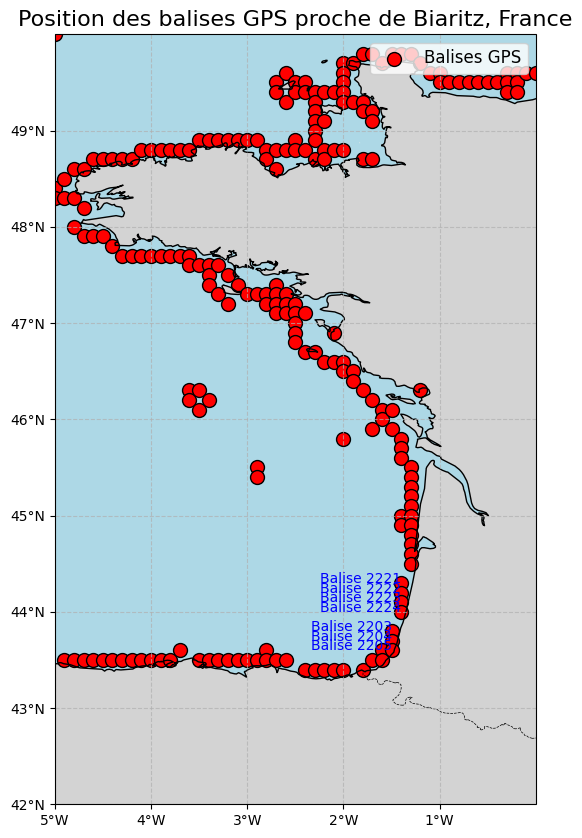

In [49]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature

# Extraire les coordonnées des stations et leur identifiant "locs"
longitude = ds['station_x_coordinate'].values
latitude = ds['station_y_coordinate'].values
locs = ds['locs'].values  # Identifiants des balises

# Créer une figure avec une projection géographique
fig, ax = plt.subplots(subplot_kw={'projection': ccrs.PlateCarree()}, figsize=(12, 10))

# Centrer la carte sur l'Europe (limites : longitude et latitude)
ax.set_extent([-5, 0, 42, 50], crs=ccrs.PlateCarree())  # Europe et alentours

# Ajouter des fonds de carte
ax.add_feature(cfeature.COASTLINE, linewidth=1)  # Lignes de côtes
ax.add_feature(cfeature.BORDERS, linestyle='--', linewidth=0.5)  # Frontières
ax.add_feature(cfeature.LAND, facecolor='lightgray')  # Continents en gris clair
ax.add_feature(cfeature.OCEAN, facecolor='lightblue')  # Océans en bleu clair
ax.add_feature(cfeature.LAKES, edgecolor='blue', facecolor='lightblue')  # Lacs

# Filtrer uniquement les points où un "locs" est défini
valid_indices = ~np.isnan(locs)  # Identifie les balises avec un locs non-NaN
filtered_longitude = longitude[valid_indices]
filtered_latitude = latitude[valid_indices]
filtered_locs = locs[valid_indices]

# Tracer les positions des balises filtrées
sc = ax.scatter(
    filtered_longitude, filtered_latitude, 
    s=100, color='red', edgecolor='k', 
    transform=ccrs.PlateCarree(), label='Balises GPS'
)

# Ajouter une légende
ax.legend(fontsize=12, loc='upper right')

# Ajouter une grille de latitude et longitude
ax.grid(True, linestyle="--", alpha=0.7)
ax.set_xticks(range(-5, 0, 1))  # Plages de longitude
ax.set_yticks(range(42, 50, 1))  # Plages de latitude
ax.xaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{x}°E' if x >= 0 else f'{-x}°W'))
ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: f'{y}°N'))

for lon, lat, loc in zip(filtered_longitude, filtered_latitude, filtered_locs):
    # Condition : annoter uniquement si locs est entre 1700 et 2200
    if  (2203<= loc <= 2205) or  (2221<= loc <= 2224):
        ax.text(
            lon, lat,
            f"Balise {int(loc)}",
            fontsize=10, ha='right', color='blue', transform=ccrs.PlateCarree()
        )
# Ajouter un titre
ax.set_title('Position des balises GPS proche de Biaritz, France', fontsize=16)

plt.show()


In [50]:
# choix de la balise, arbitraire
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature

# Extraire les coordonnées des stations
longitude = ds['station_x_coordinate'].values
latitude = ds['station_y_coordinate'].values

# Créer une figure avec une projection géographique
fig, ax = plt.subplots(subplot_kw={'projection': ccrs.PlateCarree()}, figsize=(12, 10))

# Centrer la carte sur la côte de la mer du Nord (limites : longitude et latitude)
ax.set_extent([-5, 0, 50, 55], crs=ccrs.PlateCarree())  # Cote mer du Nord

# Ajouter des fonds de carte
ax.add_feature(cfeature.COASTLINE, linewidth=1)  # Lignes de côtes
ax.add_feature(cfeature.BORDERS, linestyle='--', linewidth=0.5)  # Frontières
ax.add_feature(cfeature.LAND, facecolor='lightgray')  # Continents en gris clair
ax.add_feature(cfeature.OCEAN, facecolor='lightblue')  # Océans en bleu clair

# Tracer les positions des balises
sc = ax.scatter(longitude, latitude, s=100, color='red', edgecolor='k', transform=ccrs.PlateCarree(), label='Balises GPS')
# Ajouter une grille de latitude et longitude
ax.grid(True)  # Afficher la grille
ax.set_xticks(range(-5, 10, 1))  # Plages de longitude (modifiables)
ax.set_yticks(range(50, 55, 1))  # Plages de latitude (modifiables)
ax.xaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{x}°E' if x >= 0 else f'{-x}°W'))
ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: f'{y}°N'))

# Afficher les numéros de chaque balise à côté de sa position
for i, (lon, lat) in enumerate(zip(longitude, latitude)):
    if 3 <= lon <= 4 and 53 <= lat <= 54:  # Afficher uniquement pour la mer du Nord
        ax.text(lon, lat, str(i), fontsize=10, ha='right', color='blue', transform=ccrs.PlateCarree())

# Ajouter une légende
ax.legend(fontsize=12, loc='upper right')

# Ajouter un titre
ax.set_title('Position des balises GPS sur la Côte de la Mer du Nord', fontsize=16)

plt.show()





## choix balise et fusion des tables 2016 et 2017 

In [64]:
numero_balise = 2205

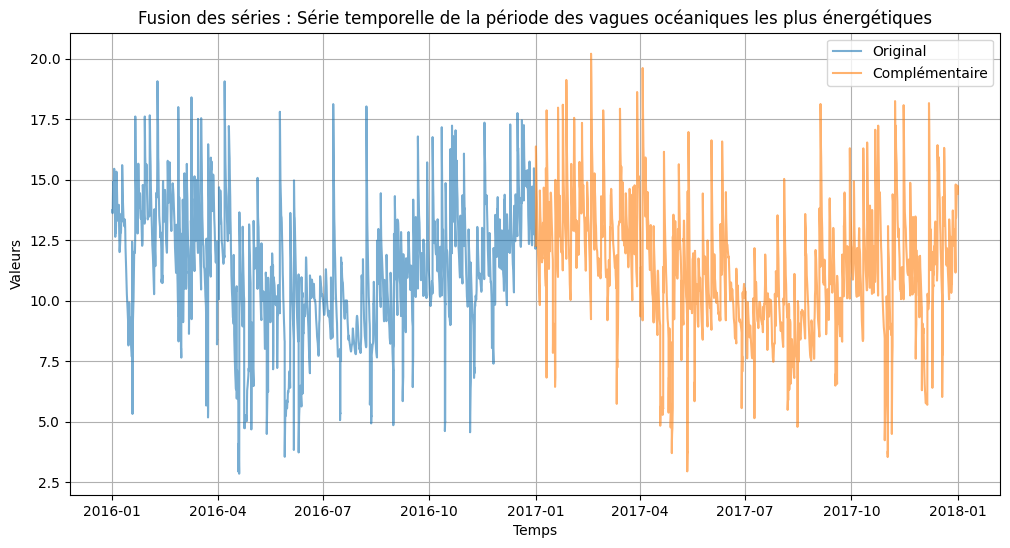

In [65]:
temps_moyen_entre_les_vagues_2016_biarritz = xr.open_dataset(netcdf_files[0])['mp1'].isel(locs=numero_balise)
direction_moyene_des_vagues_2016_biarritz  = xr.open_dataset(netcdf_files[2])['mwd'].isel(locs=numero_balise)
temps_moyen_entre_les_vagues_energetiques_2016_biarritz = xr.open_dataset(netcdf_files[4])['pp1d'].isel(locs=numero_balise)
hauteur_moyenne_du_tier_des_vagues_les_plus_hautes_2016_biarritz  = xr.open_dataset(netcdf_files[6])['swh'].isel(locs=numero_balise)
tables_2016 = [
    temps_moyen_entre_les_vagues_2016_biarritz ,
    direction_moyene_des_vagues_2016_biarritz ,
    temps_moyen_entre_les_vagues_energetiques_2016_biarritz ,
    hauteur_moyenne_du_tier_des_vagues_les_plus_hautes_2016_biarritz 
]

temps_moyen_entre_les_vagues_2017_biarritz  = xr.open_dataset(netcdf_files[1])['mp1'].isel(locs=numero_balise)
direction_moyene_des_vagues_2017_biarritz  = xr.open_dataset(netcdf_files[3])['mwd'].isel(locs=numero_balise)
temps_moyen_entre_les_vagues_energetiques_2017_biarritz  = xr.open_dataset(netcdf_files[5])['pp1d'].isel(locs=numero_balise)
hauteur_moyenne_du_tier_des_vagues_les_plus_hautes_2017_biarritz  = xr.open_dataset(netcdf_files[7])['swh'].isel(locs=numero_balise)

# Listes des séries temporelles originales et complémentaires
tables_2017 =[
    temps_moyen_entre_les_vagues_2017_biarritz ,
    direction_moyene_des_vagues_2017_biarritz ,
    temps_moyen_entre_les_vagues_energetiques_2017_biarritz ,
    hauteur_moyenne_du_tier_des_vagues_les_plus_hautes_2017_biarritz 
]

titles = [
    "Série temporelle du temps moyen entre les vagues",
    "Série temporelle de la direction moyenne des vagues",
    "Série temporelle de la période des vagues océaniques les plus énergétiques",
    "Série temporelle de la hauteur moyenne (mètre) du tiers le plus élevé des vagues"
]

merged_table_names = [
    "temps_moyen_entre_les_vagues_2016_2017_biarritz ",
    "direction_moyene_des_vagues_2016_2017_biarritz ",
    "temps_moyen_entre_les_vagues_energetiques_2016_2017_biarritz ",
    "hauteur_moyenne_du_tier_des_vagues_les_plus_hautes_2016_2017_biarritz "
]

# Concaténer les DataArrays pour chaque variable
temps_moyen_entre_les_vagues_2016_2017_biarritz = xr.concat([tables_2016[0], tables_2017[0]], dim="time")
direction_moyene_des_vagues_2016_2017_biarritz = xr.concat([tables_2016[1], tables_2017[1]], dim="time")
temps_moyen_entre_les_vagues_energetiques_2016_2017_biarritz = xr.concat([tables_2016[2], tables_2017[2]], dim="time")
hauteur_moyenne_du_tier_des_vagues_les_plus_hautes_2016_2017_biarritz = xr.concat([tables_2016[3], tables_2017[3]], dim="time")

# Initialiser le dictionnaire final et la liste des tables fusionnées

merged_tables_list = [temps_moyen_entre_les_vagues_2016_2017_biarritz,
direction_moyene_des_vagues_2016_2017_biarritz,
temps_moyen_entre_les_vagues_energetiques_2016_2017_biarritz ,
hauteur_moyenne_du_tier_des_vagues_les_plus_hautes_2016_2017_biarritz]

tables = {
    "Temps moyen entre les vagues": temps_moyen_entre_les_vagues_2016_2017_biarritz,
    "Direction moyenne des vagues": direction_moyene_des_vagues_2016_2017_biarritz,
    "Période des vagues énergétiques": temps_moyen_entre_les_vagues_energetiques_2016_2017_biarritz,
    "Hauteur moyenne des vagues les plus hautes": hauteur_moyenne_du_tier_des_vagues_les_plus_hautes_2016_2017_biarritz,
}

# Fusion des tables originales avec les complémentaires
for name, original, complementaire, title in zip(titles, tables_2016, tables_2017, titles):
  
    # Visualisation de la fusion pour vérification
    plt.figure(figsize=(12, 6))
    plt.plot(original["time"], original.values, label="Original", alpha=0.6)
    plt.plot(complementaire["time"], complementaire.values, label="Complémentaire", alpha=0.6)
    plt.title(f"Fusion des séries : {title}")
    plt.xlabel("Temps")
    plt.ylabel("Valeurs")
    plt.legend()
    plt.grid()
    plt.show()


## Graphique des séries

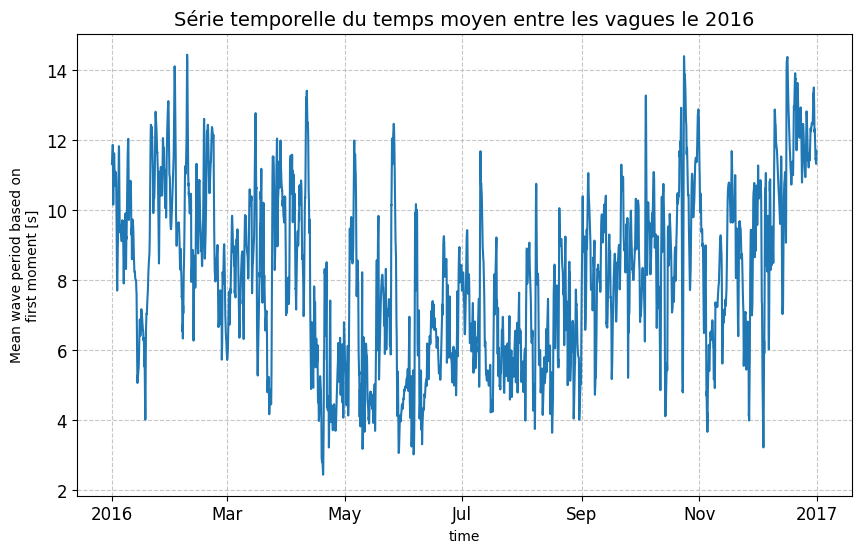

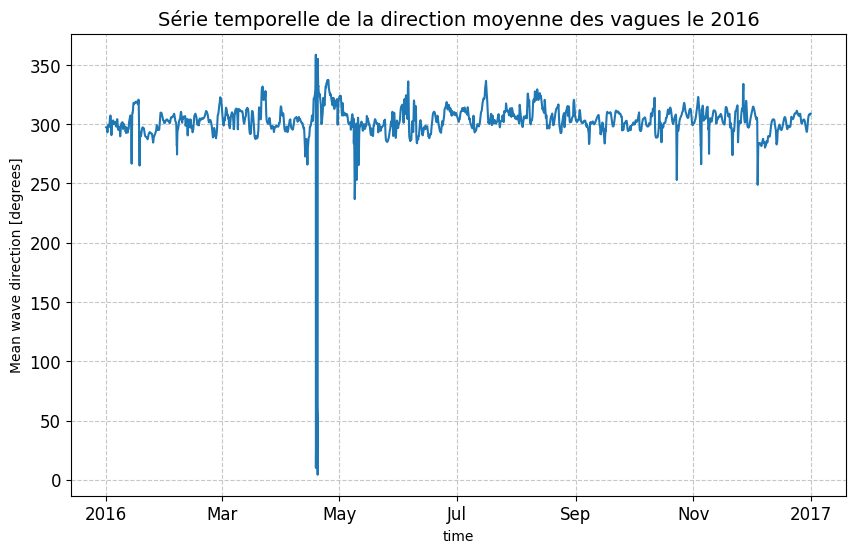

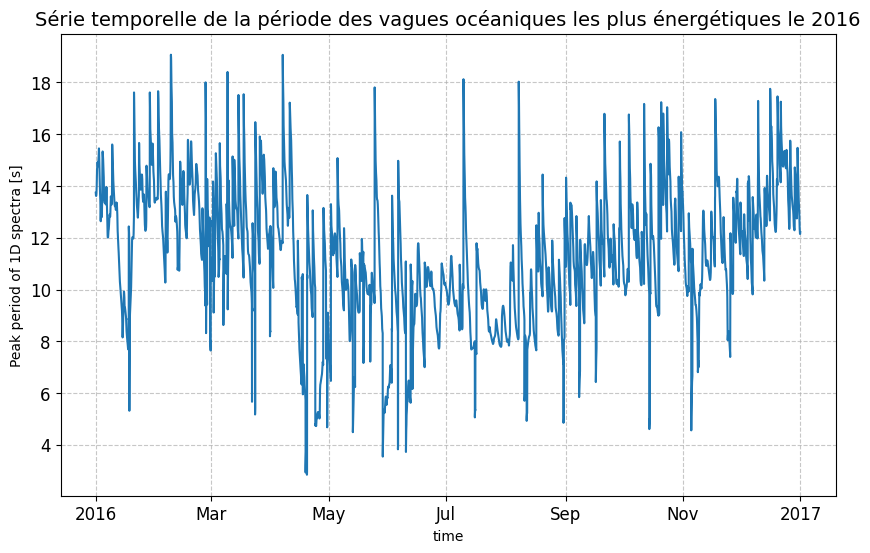

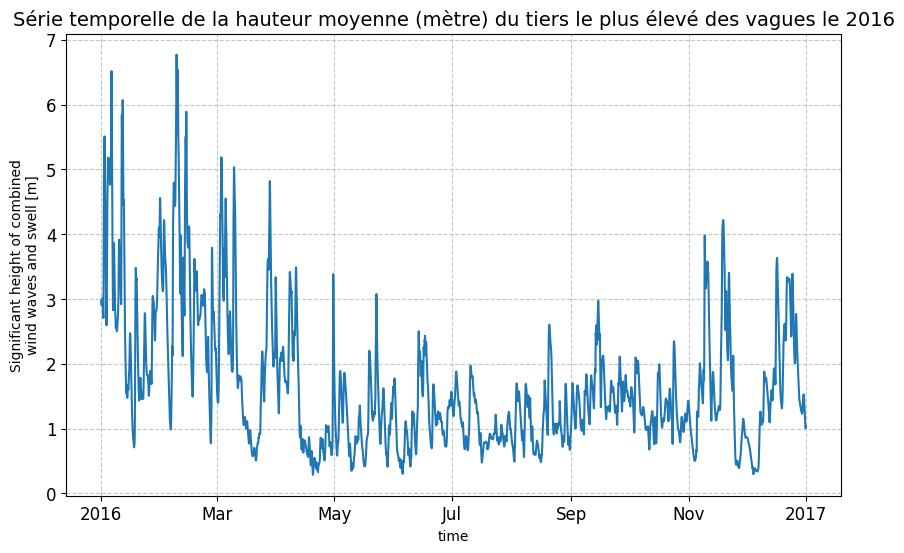

In [53]:
date_filtre = "2016"
for table, title in zip(merged_tables_list, titles):
    data_filtre = table.sel(time=date_filtre)
    fig, ax = plt.subplots(figsize=(10, 6))
    data_filtre.plot(ax=ax)  # Tracer les données filtrées
    ax.tick_params(axis='both', which='major', labelsize=12)  # Taille des labels des axes
    ax.set_title(f"{title} le {date_filtre}", fontsize=14)  # Ajouter le titre correspondant
    ax.grid(True, linestyle='--', alpha=0.7)
    
    plt.show()


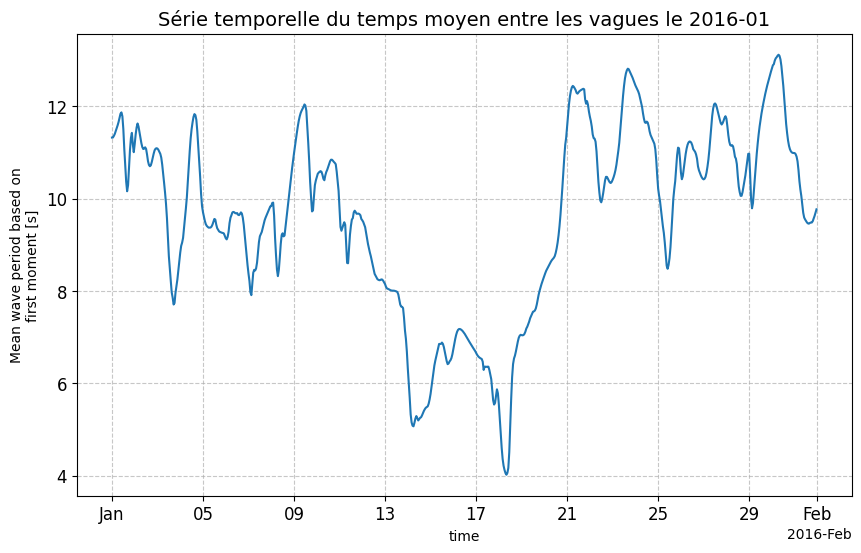

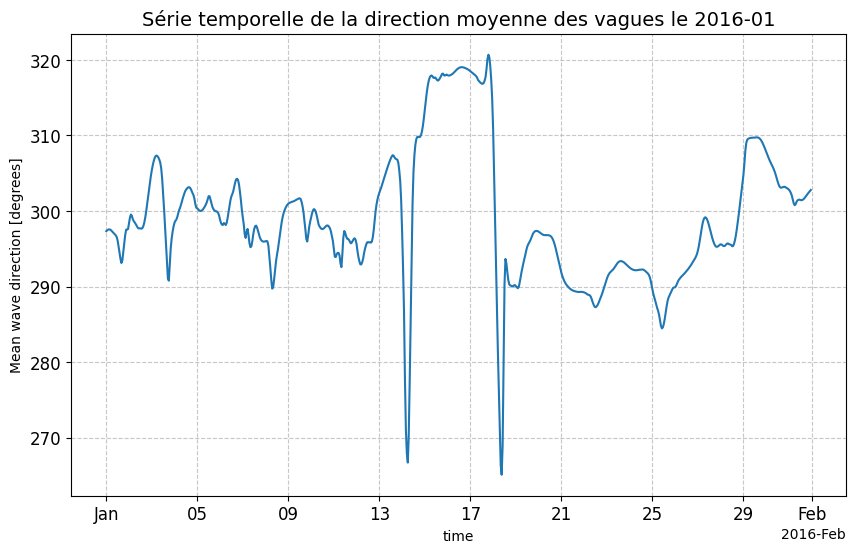

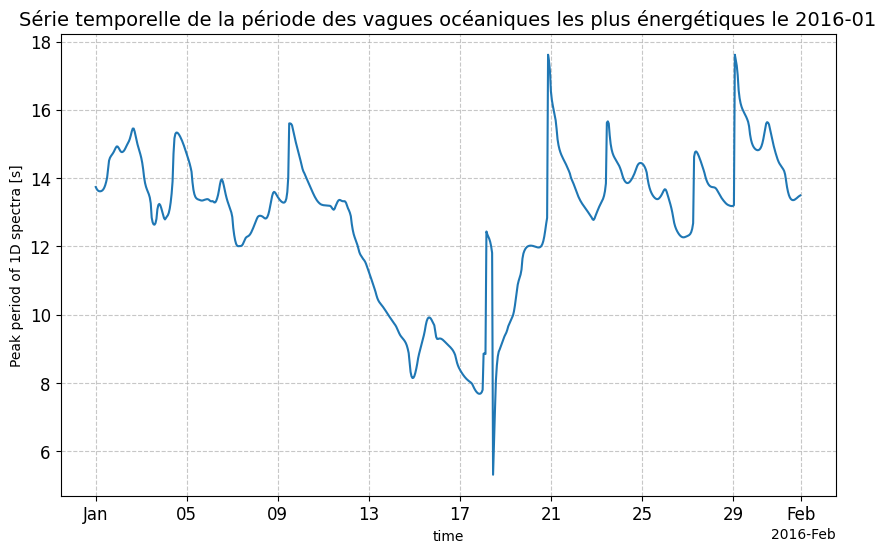

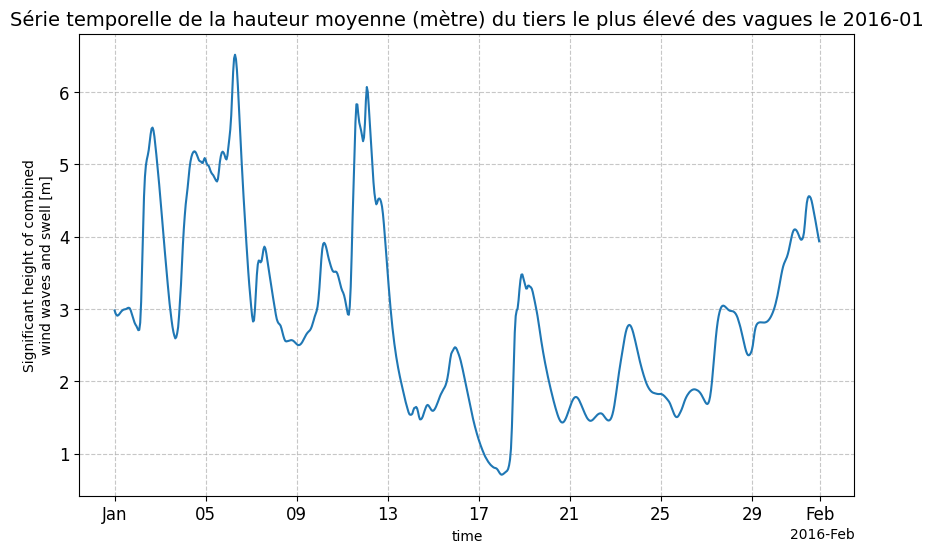

In [54]:
date_filtre = "2016-01"
for table, title in zip(merged_tables_list, titles):
    data_filtre = table.sel(time=date_filtre)
    fig, ax = plt.subplots(figsize=(10, 6))
    data_filtre.plot(ax=ax)  # Tracer les données filtrées
    ax.tick_params(axis='both', which='major', labelsize=12)  # Taille des labels des axes
    ax.set_title(f"{title} le {date_filtre}", fontsize=14)  # Ajouter le titre correspondant
    ax.grid(True, linestyle='--', alpha=0.7)
    
    # Afficher le graphique
    plt.show()

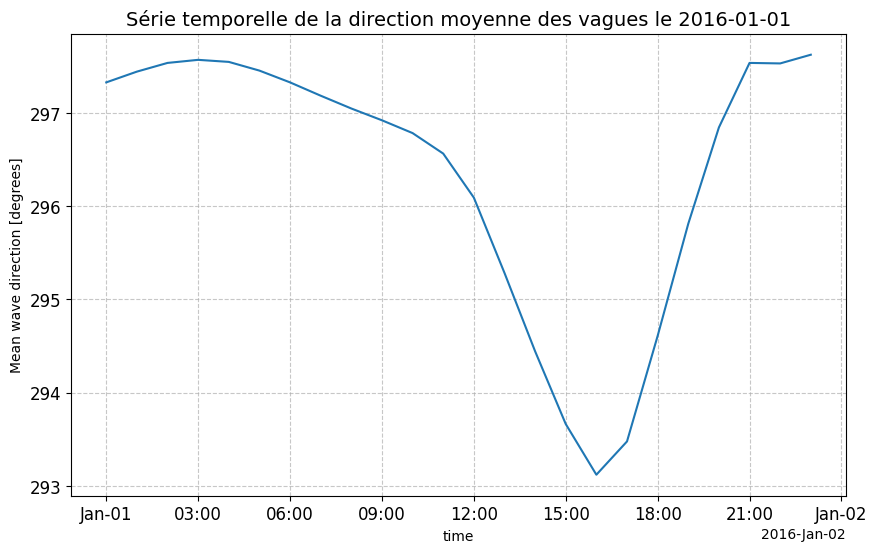

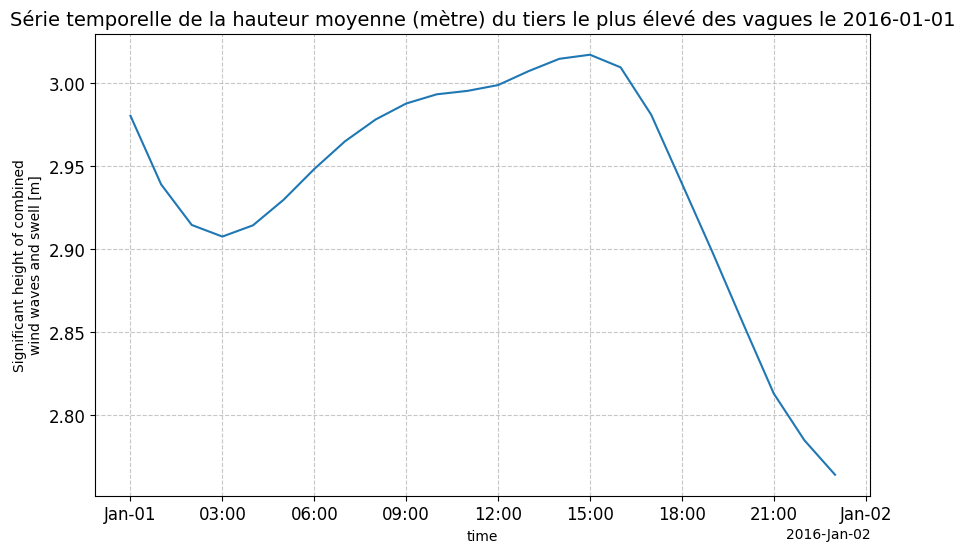

In [55]:
date_filtre = "2016-01-01"
for table, title in zip(merged_tables_list, titles):
    data_filtre = table.sel(time=date_filtre)
    fig, ax = plt.subplots(figsize=(10, 6))
    data_filtre.plot(ax=ax)  # Tracer les données filtrées
    ax.tick_params(axis='both', which='major', labelsize=12)  # Taille des labels des axes
    ax.set_title(f"{title} le {date_filtre}", fontsize=14)  # Ajouter le titre correspondant
    ax.grid(True, linestyle='--', alpha=0.7)
    
    # Afficher le graphique
    plt.show()

In [67]:
tables = {
    "Temps moyen entre les vagues": temps_moyen_entre_les_vagues_2016_2017_biarritz,
    "Direction moyenne des vagues": direction_moyene_des_vagues_2016_2017_biarritz,
    "Période des vagues énergétiques": temps_moyen_entre_les_vagues_energetiques_2016_2017_biarritz,
    "Hauteur moyenne des vagues les plus hautes": hauteur_moyenne_du_tier_des_vagues_les_plus_hautes_2016_2017_biarritz,
}

data_list = []
for name, data in tables.items():
    df = pd.DataFrame({
        "time": data["time"].values,
        "value": data.values,
        "variable": name
    })
    df["Month"] = pd.to_datetime(df["time"]).dt.strftime("%b")  # Extraire le mois
    data_list.append(df)

all_data = pd.concat(data_list, ignore_index=True)

month_order = ["Jan", "Feb", "Mar", "Apr", "May", "Jun", "Jul", "Aug", "Sep", "Oct", "Nov", "Dec"]

fig, axes = plt.subplots(len(tables), 1, figsize=(15, 12), sharex=True)

for (name, ax) in zip(tables.keys(), axes):
    sns.boxplot(
        data=all_data[all_data["variable"] == name],
        x="Month", y="value",
        ax=ax, order=month_order, palette="coolwarm"
    )
    ax.set_ylabel("Valeur", fontsize=12)
    ax.set_title(name, fontsize=14)
    ax.grid(True, linestyle="--", alpha=0.7)

axes[-1].set_xlabel("Mois", fontsize=12)

plt.tight_layout()
plt.show()

C:\Users\vongu\AppData\Local\Temp\ipykernel_16876\1156691689.py:25: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(
C:\Users\vongu\AppData\Local\Temp\ipykernel_16876\1156691689.py:25: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(
C:\Users\vongu\AppData\Local\Temp\ipykernel_16876\1156691689.py:25: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(
C:\Users\vongu\AppData\Local\Temp\ipykernel_16876\1156691689.py:25: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `h

## Analyse de la saisonnalité

NameError: name 'mois_filtre' is not defined

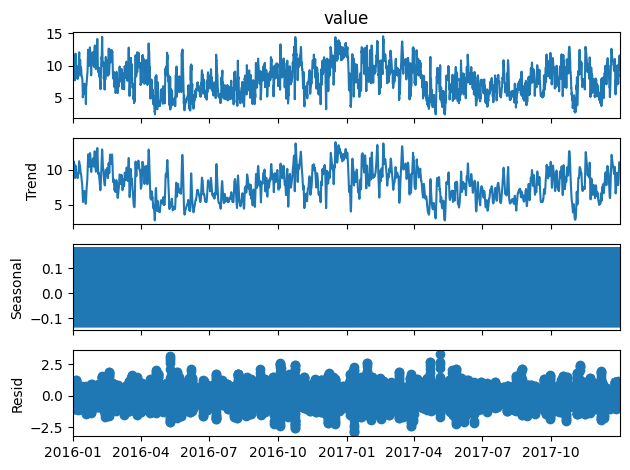

In [69]:

tables = {
    "Temps moyen entre les vagues": temps_moyen_entre_les_vagues_2016_2017_biarritz,
    "Direction moyenne des vagues": direction_moyene_des_vagues_2016_2017_biarritz,
    "Période des vagues énergétiques": temps_moyen_entre_les_vagues_energetiques_2016_2017_biarritz,
    "Hauteur moyenne des vagues les plus hautes": hauteur_moyenne_du_tier_des_vagues_les_plus_hautes_2016_2017_biarritz,
}

for name, data in tables.items():
    df = pd.DataFrame({"time": data["time"].values, "value": data.values}).set_index("time")
    
    # Vérifier qu'il y a des données après filtrage
    if len(df) == 0:
        print(f"Pas de données disponibles pour {name} en {mois_filtre}.")
        continue
    
    # Effectuer la décomposition saisonnière
    decomposition = seasonal_decompose(df["value"], model="additive", period=24)  # Période = 24 heures (ajustable)
    
    # Tracer le résultat
    fig = decomposition.plot()
    fig.suptitle(f"Décomposition saisonnière - {name} ({mois_filtre})", fontsize=16)  # Ajouter un titre
    fig.set_size_inches(12, 8)  # Ajuster la taille du graphique
    plt.show()

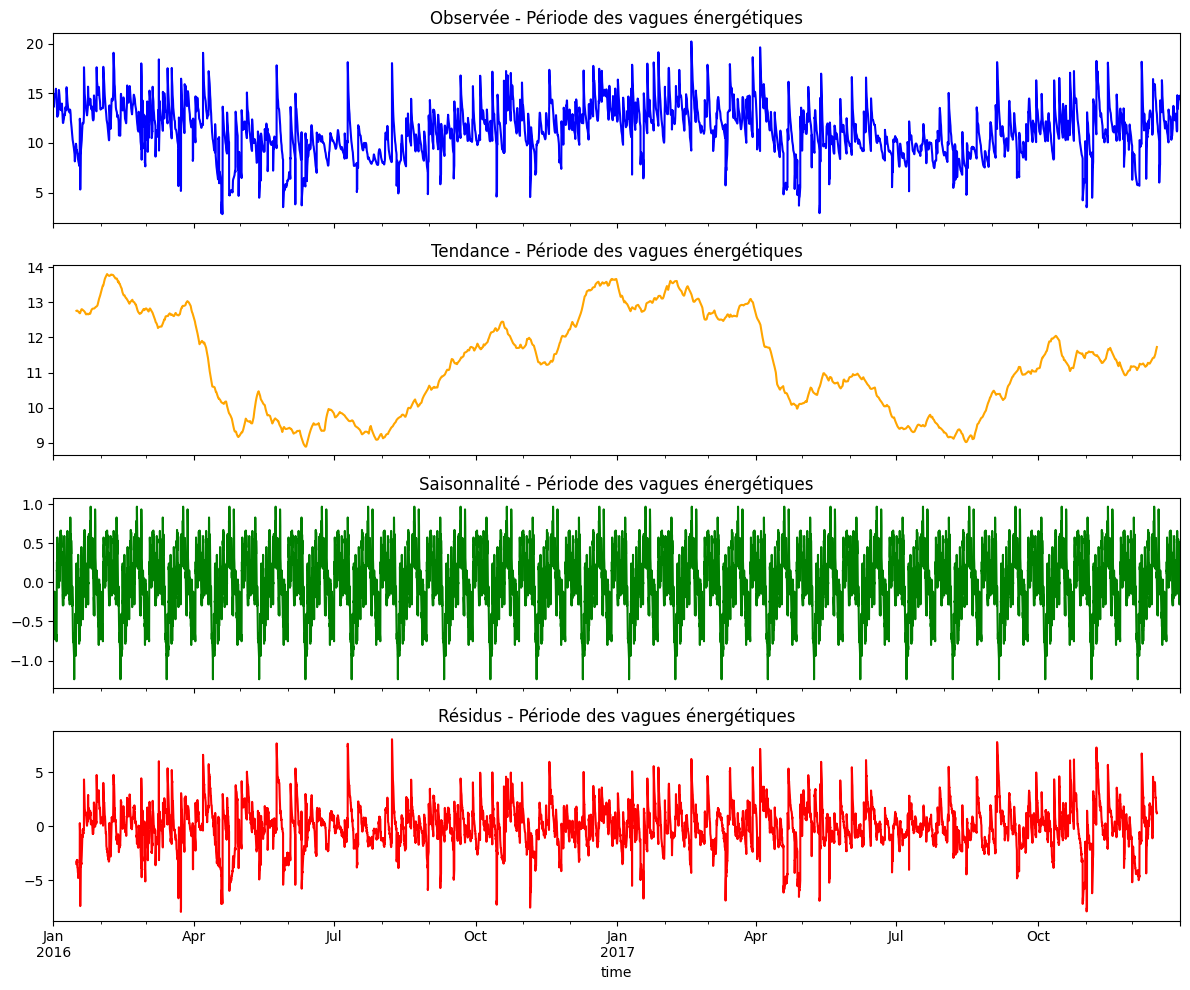

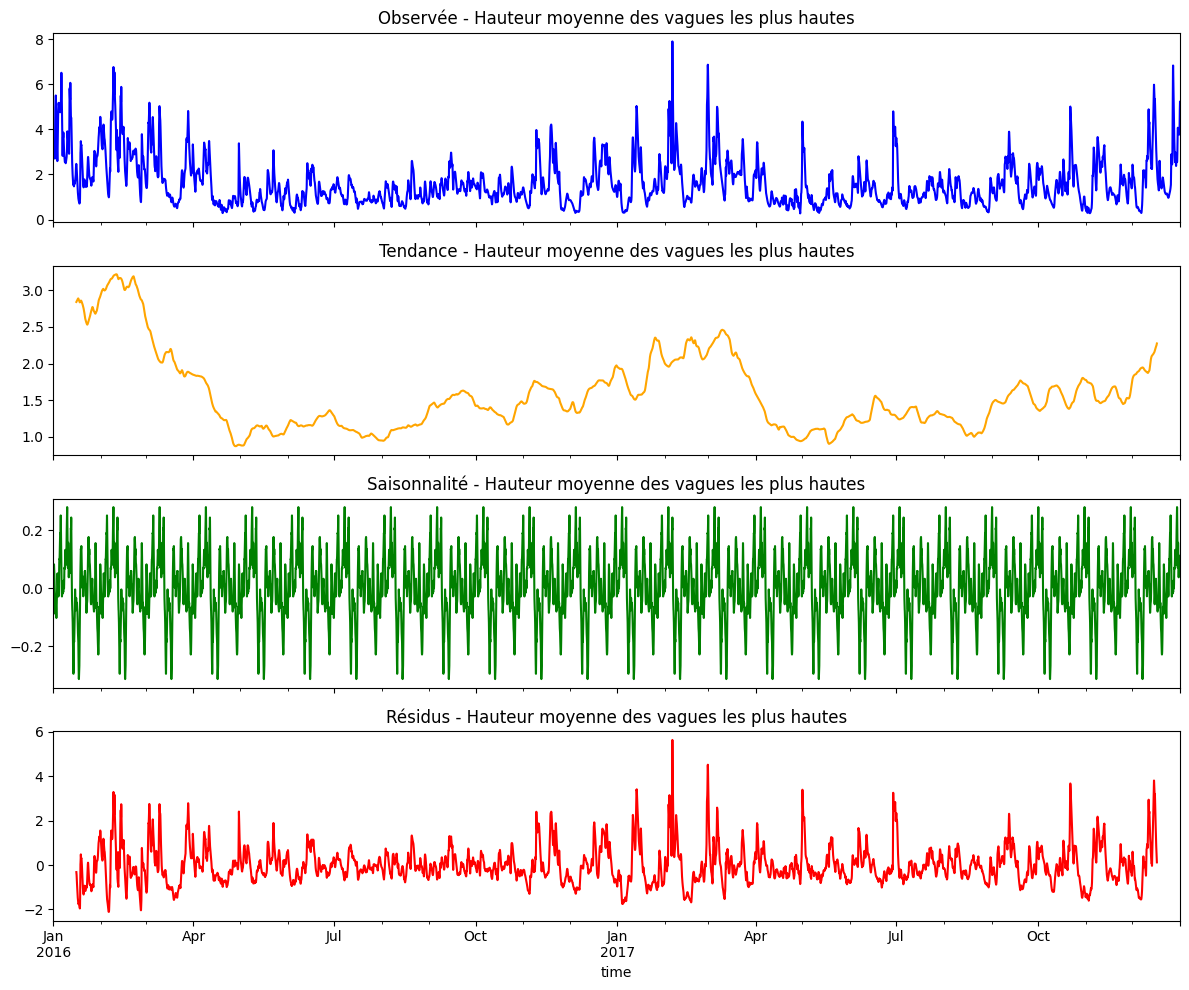

In [97]:
from statsmodels.tsa.seasonal import seasonal_decompose

tables = {
    "Temps moyen entre les vagues": temps_moyen_entre_les_vagues_2016_2017_biarritz,
    "Direction moyenne des vagues": direction_moyene_des_vagues_2016_2017_biarritz,
    "Période des vagues énergétiques": temps_moyen_entre_les_vagues_energetiques_2016_2017_biarritz,
    "Hauteur moyenne des vagues les plus hautes": hauteur_moyenne_du_tier_des_vagues_les_plus_hautes_2016_2017_biarritz,
}

# Décomposition de la série temporelle et agrégation par mois
for name, data in tables.items():
    df = pd.DataFrame({"time": data["time"].values, "value": data.values}).set_index("time")
    if len(df) == 0:
        print(f"Pas de données disponibles pour {name}.")
        continue
    
    # Décomposition de la série temporelle
    decomposition = seasonal_decompose(df["value"], model="additif", period=24*30)  # Approximation d'une périodicité mensuelle
    
    # Tracer les composants de la décomposition
    fig, axes = plt.subplots(4, 1, figsize=(12, 10), sharex=True)
    decomposition.observed.plot(ax=axes[0], title=f"Observée - {name}", color="blue")
    decomposition.trend.plot(ax=axes[1], title=f"Tendance - {name}", color="orange")
    decomposition.seasonal.plot(ax=axes[2], title=f"Saisonnalité - {name}", color="green")
    decomposition.resid.plot(ax=axes[3], title=f"Résidus - {name}", color="red")
    plt.tight_layout()
    plt.show()
    

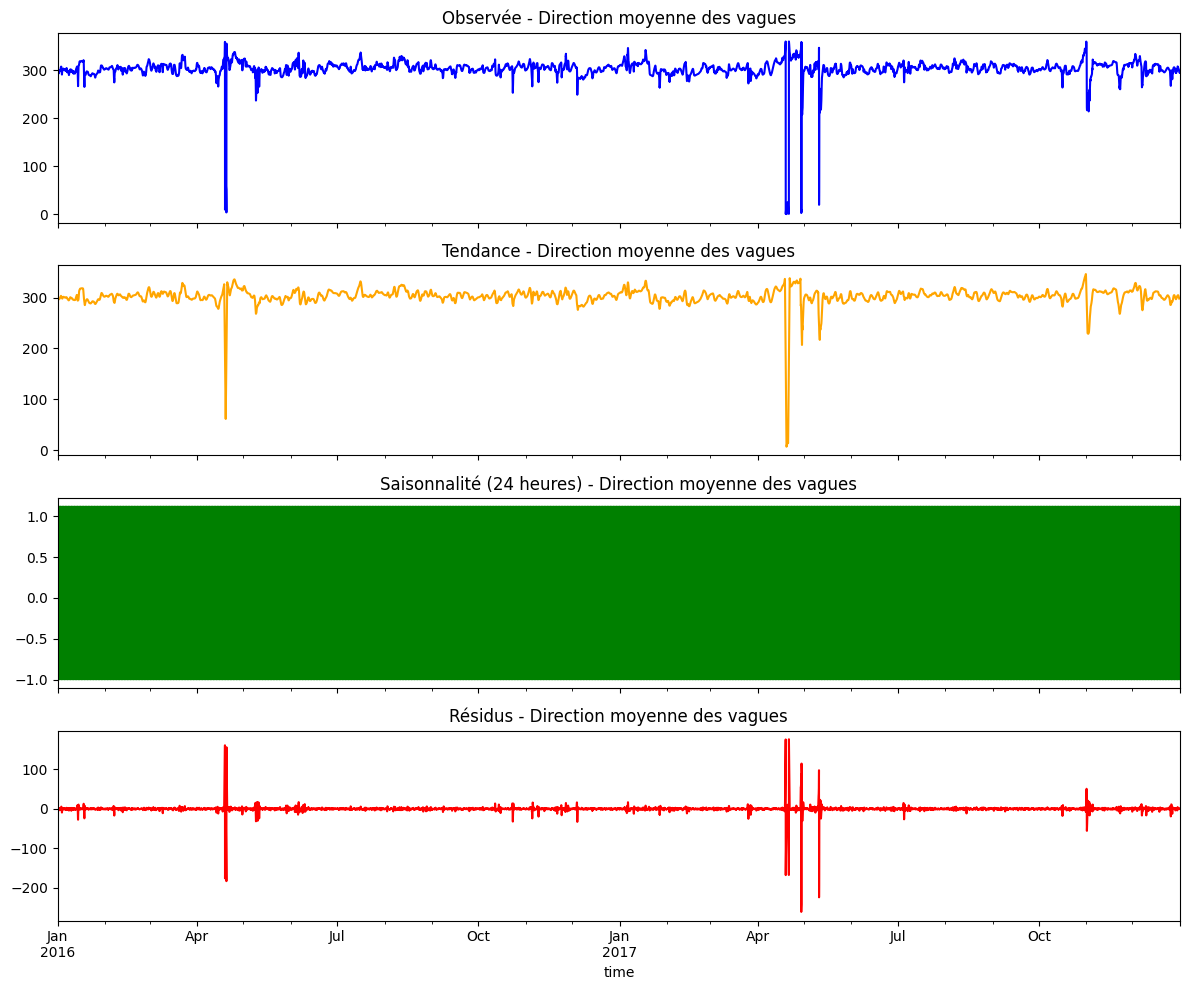

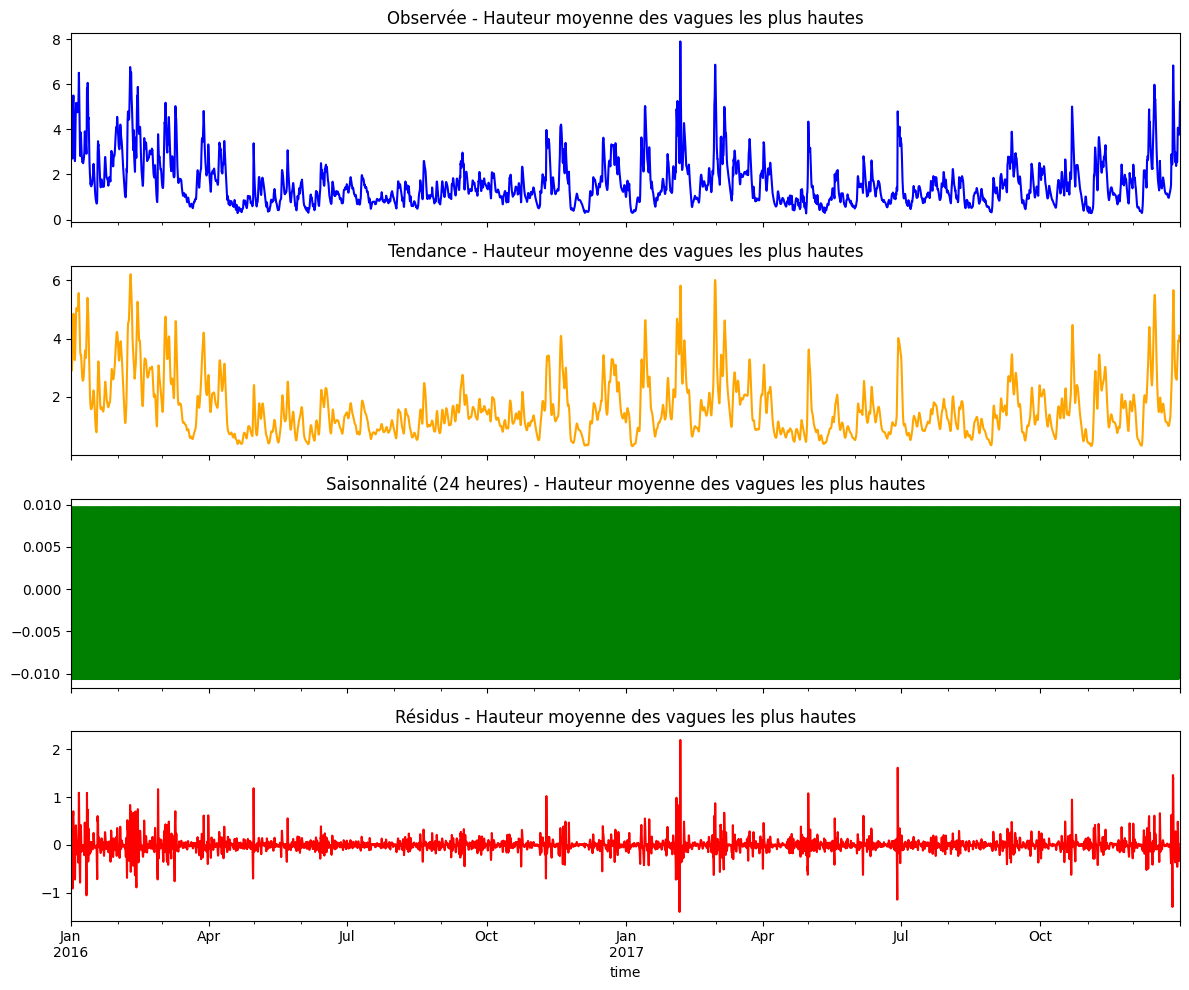

In [98]:
# Décomposition de la série temporelle avec une période de 24 heures
for name, data in tables.items():
    df = pd.DataFrame({"time": data["time"].values, "value": data.values}).set_index("time")
    if len(df) == 0:
        print(f"Pas de données disponibles pour {name}.")
        continue
    
    # Décomposition de la série temporelle avec une période de 24 heures
    decomposition = seasonal_decompose(df["value"], model="additive", period=24)  # Périodicité journalière
    
    # Tracer les composants de la décomposition
    fig, axes = plt.subplots(4, 1, figsize=(12, 10), sharex=True)
    decomposition.observed.plot(ax=axes[0], title=f"Observée - {name}", color="blue")
    decomposition.trend.plot(ax=axes[1], title=f"Tendance - {name}", color="orange")
    decomposition.seasonal.plot(ax=axes[2], title=f"Saisonnalité (24 heures) - {name}", color="green")
    decomposition.resid.plot(ax=axes[3], title=f"Résidus - {name}", color="red")
    plt.tight_layout()
    plt.show()


In [ ]:
# # Dunkerke
# lat_target = 56
# lon_target = 4

# filtered_datasets = []
# for file in netcdf_files:
#     # Charger le fichier NetCDF avec xarray
#     ds = xr.open_dataset(file)
    
#     # Utiliser "locs" pour sélectionner les indices de stations les plus proches
#     filtered_data = ds.sel(locs=1000)
#     df = filtered_data.to_dataframe().reset_index()

#     # Ajouter le dataset filtré à la liste
#     filtered_datasets.append(df)



## Anlayse de la stationnarité faible



Par ex : Relation linéaire entre période 3 et 5 ?
Faible stationnarité sur moment 2 implique que l’autovariance dépend que de t-s mais pas de t ni de s. Donc même effet entre 3 et 5 et 4 et 6. Le poids du passé reste égal dans le temps = stationnaire. 

Si le processus admet une espérance constante, une variance et une covariance qui d"pendent du temps. Le processus, n'est pas stationnaire 

DF augmenté : si résidus ne sont pas blanc, DF est faux. 

Test de stationnarité (ADF) :

Nous appliquons le test ADF sur les séries d'origine pour déterminer si elles sont stationnaires (I(0)).
Si la p-valeur du test est inférieure à 0.05, cela signifie que la série est stationnaire (I(0)).
Sinon, nous poursuivons la différenciation.
Différenciation (I(1) et I(2)) :
Si la série n'est pas stationnaire après le test ADF, nous procédons à une différenciation d'ordre 1 (I(1)) et testons à nouveau la stationnarité avec ADF.
Si la série est toujours non stationnaire après I(1), nous effectuons une différenciation d'ordre 2 (I(2)) et refaisons le test.

In [71]:

tables = {
    "Temps moyen entre les vagues": temps_moyen_entre_les_vagues_2016_2017_biarritz,
    "Direction moyenne des vagues": direction_moyene_des_vagues_2016_2017_biarritz,
    "Période des vagues énergétiques": temps_moyen_entre_les_vagues_energetiques_2016_2017_biarritz,
    "Hauteur moyenne des vagues les plus hautes": hauteur_moyenne_du_tier_des_vagues_les_plus_hautes_2016_2017_biarritz,
}

# Fonction pour tester la stationnarité avec ADF
def test_stationarity(series, name="Série"):
    """
    Test de stationnarité sur une série temporelle avec le test ADF.
    """
    print(f"\nTest de stationnarité pour : {name}")
    
    # Suppression des valeurs manquantes en fonction de la dimension 'time'
    series_clean = series.dropna(dim='time')
    
    adf_test = adfuller(series_clean)  # ADF sur les données sans valeurs manquantes
    adf_stat, p_value, lags, obs, crit_values, icbest = adf_test

    print(f"Statistique ADF : {adf_stat:.3f}")
    print(f"P-valeur : {p_value:.3g}")
    print(f"Lags utilisés : {lags}")
    print(f"Valeurs critiques : {crit_values}")

    if p_value < 0.05:
        print(f"La série '{name}' est stationnaire (H0 rejetée).")
        return "I(0)"  # Stationnaire
    else:
        print(f"La série '{name}' n'est PAS stationnaire (H0 non rejetée).")
        return "Non stationnaire"

# Fonction pour effectuer une différenciation (ordre 1 ou 2)
def differentiate(series, order=1):
    """
    Effectuer une différenciation d'ordre spécifié sur une série temporelle.
    """
    return series.diff(dim='time', periods=order).dropna(dim='time')  # Différenciation et suppression des NaN

# Analyser les séries et tester la stationnarité
for name, data in tables.items():
    print(f"\n=== Analyse de stationnarité pour : {name} ===")
    
    # Test de stationnarité pour la série d'origine (I(0))
    result = test_stationarity(data, name=name)
    
    if result == "Non stationnaire":
        # Différencier d'ordre 1 (I(1)) et tester à nouveau
        data_diff_1 = differentiate(data, order=1)
        print(f"\nSérie différenciée d'ordre 1 pour {name}:")
        test_stationarity(data_diff_1, name=f"{name} - Différenciée d'ordre 1")
        
        # Si la série n'est pas stationnaire après différenciation d'ordre 1, différencier d'ordre 2 (I(2))
        data_diff_2 = differentiate(data_diff_1, order=1)
        print(f"\nSérie différenciée d'ordre 2 pour {name}:")
        test_stationarity(data_diff_2, name=f"{name} - Différenciée d'ordre 2")



=== Analyse de stationnarité pour : Temps moyen entre les vagues ===

Test de stationnarité pour : Temps moyen entre les vagues
Statistique ADF : -9.350
P-valeur : 8.36e-16
Lags utilisés : 36
Valeurs critiques : {'1%': -3.430723579658173, '5%': -2.86170510778413, '10%': -2.5668578825869712}
La série 'Temps moyen entre les vagues' est stationnaire (H0 rejetée).

=== Analyse de stationnarité pour : Direction moyenne des vagues ===

Test de stationnarité pour : Direction moyenne des vagues
Statistique ADF : -16.634
P-valeur : 1.66e-29
Lags utilisés : 30
Valeurs critiques : {'1%': -3.4307234516500293, '5%': -2.8617050512130313, '10%': -2.5668578524750263}
La série 'Direction moyenne des vagues' est stationnaire (H0 rejetée).

=== Analyse de stationnarité pour : Période des vagues énergétiques ===

Test de stationnarité pour : Période des vagues énergétiques
Statistique ADF : -13.126
P-valeur : 1.53e-24
Lags utilisés : 14
Valeurs critiques : {'1%': -3.4307231107234646, '5%': -2.86170490054

## autocorrélation et autocorrélation partielle

Analyse de la série : Temps moyen entre les vagues


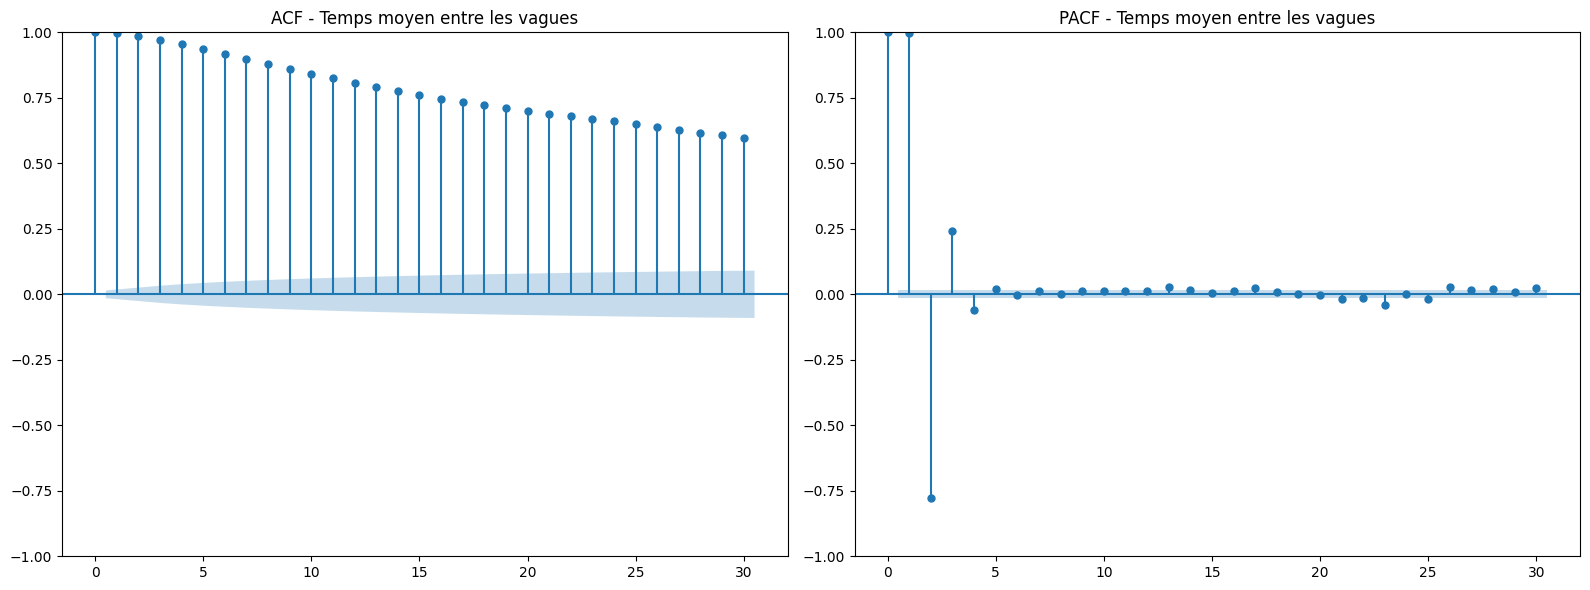

Analyse de la série : Direction moyenne des vagues


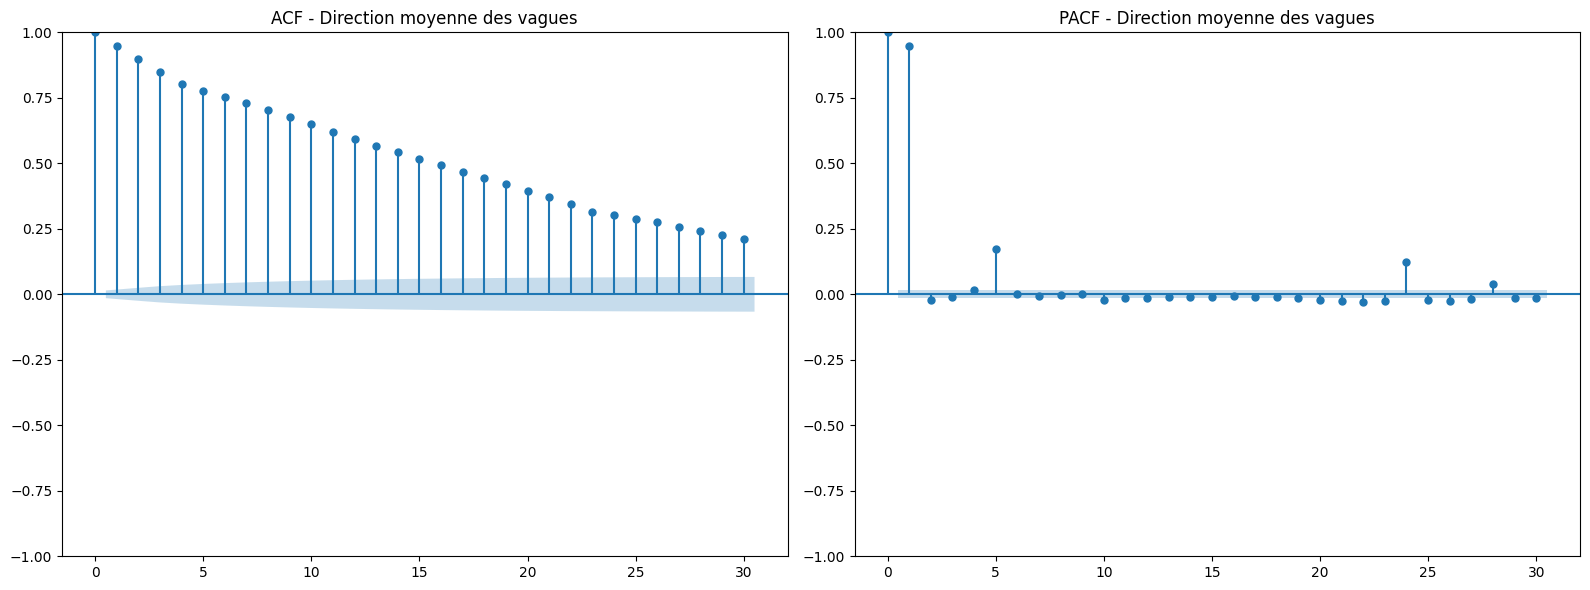

Analyse de la série : Période des vagues énergétiques


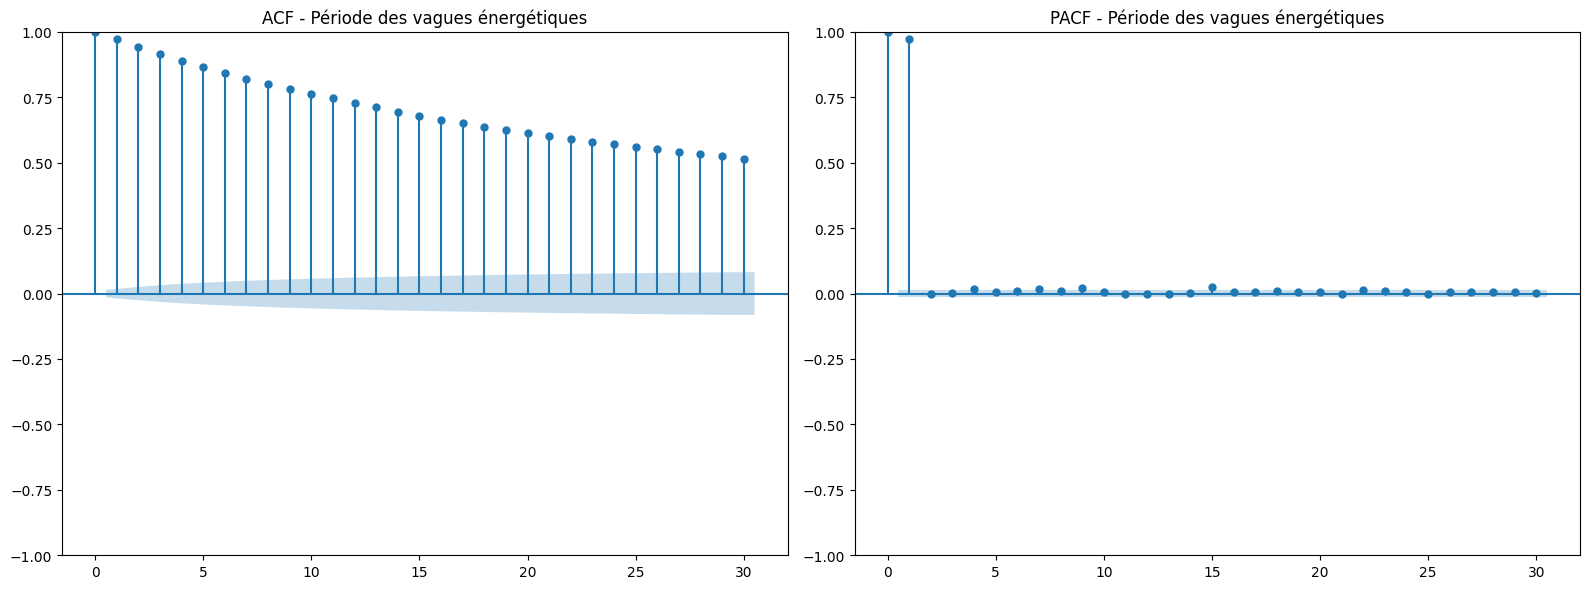

Analyse de la série : Hauteur moyenne des vagues les plus hautes


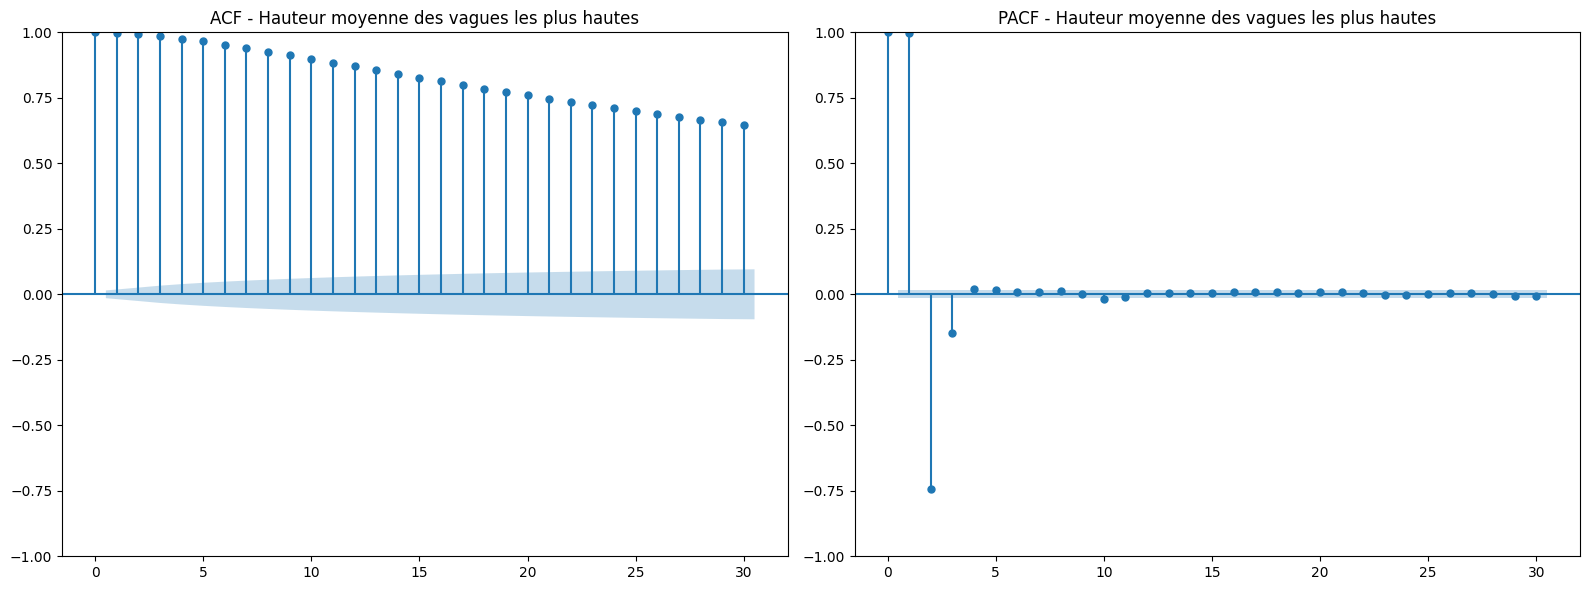

In [72]:
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf


tables = {
    "Temps moyen entre les vagues": temps_moyen_entre_les_vagues_2016_2017_biarritz,
    "Direction moyenne des vagues": direction_moyene_des_vagues_2016_2017_biarritz,
    "Période des vagues énergétiques": temps_moyen_entre_les_vagues_energetiques_2016_2017_biarritz,
    "Hauteur moyenne des vagues les plus hautes": hauteur_moyenne_du_tier_des_vagues_les_plus_hautes_2016_2017_biarritz,
}

for name, data in tables.items():
    print(f"Analyse de la série : {name}")
    series = data.values
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))
    plot_acf(series, lags=30, ax=axes[0])
    axes[0].set_title(f'ACF - {name}')
    plot_pacf(series, lags=30, ax=axes[1])
    axes[1].set_title(f'PACF - {name}')
    plt.tight_layout()
    plt.show()


L'ACF montre une décroissance progressive des corrélations avec l'augmentation du lag.
La PACF montrera une coupure nette après le deux, troisième ou cinquième lag selon la série, indiquant que seul ces premiers décalages ont ne corrélation significative une fois les autres lags pris en compte.
En résumé les séries sont très périodiques

# Préprocessing

à faire :

Preprocessing

filtre par ondelette Wavelet denoising (décomposition de fourrier)

transformation variable dégré en degré par du cos ou sin (passage donnée polaire en donnée cartésienne).direction de 1° est très proche sur une cercle de la direction 359°.

Les méthodes

stationnarité, co intégration avec les autres variables ?
mice pour NA
ts fresh pour créer variable
créer des variables à partir du temps
choisir métrique
bien decouper entrainement et test

## passage données polaire en données cartésienne pour les variables de direction


cos(radians)


In [73]:
tables = {
    "Temps moyen entre les vagues": temps_moyen_entre_les_vagues_2016_2017_biarritz,
    "Direction moyenne des vagues": direction_moyene_des_vagues_2016_2017_biarritz,
    "Période des vagues énergétiques": temps_moyen_entre_les_vagues_energetiques_2016_2017_biarritz,
    "Hauteur moyenne des vagues les plus hautes": hauteur_moyenne_du_tier_des_vagues_les_plus_hautes_2016_2017_biarritz,
}
direction_radians = np.deg2rad(direction_moyene_des_vagues_2016_2017_biarritz)  # Convertir les degrés en radians
direction_moyene_des_vagues_2016_2017_biarritz_en_cos = np.cos(direction_radians)  # Calculer le cosinus

# Stocker le résultat dans une nouvelle variable
direction_moyene_des_vagues_2016_2017_biarritz_en_cos.attrs = direction_moyene_des_vagues_2016_2017_biarritz.attrs  # Conserver les métadonnées
direction_moyene_des_vagues_2016_2017_biarritz_en_cos.name = "Cosinus de la direction moyenne des vagues"

# Afficher un aperçu des données
print(direction_moyene_des_vagues_2016_2017_biarritz_en_cos)


<xarray.DataArray 'Cosinus de la direction moyenne des vagues' (time: 17544)> Size: 140kB
array([0.45909351, 0.46088132, 0.46232722, ..., 0.42911956, 0.42556554,
       0.42139639])
Coordinates:
  * time                  (time) datetime64[ns] 140kB 2016-01-01 ... 2017-12-...
    station_x_coordinate  float64 8B 358.5
    station_y_coordinate  float64 8B 43.6
Attributes:
    units:       degrees
    long_name:   Mean wave direction
    short_name:  Mean wave direction


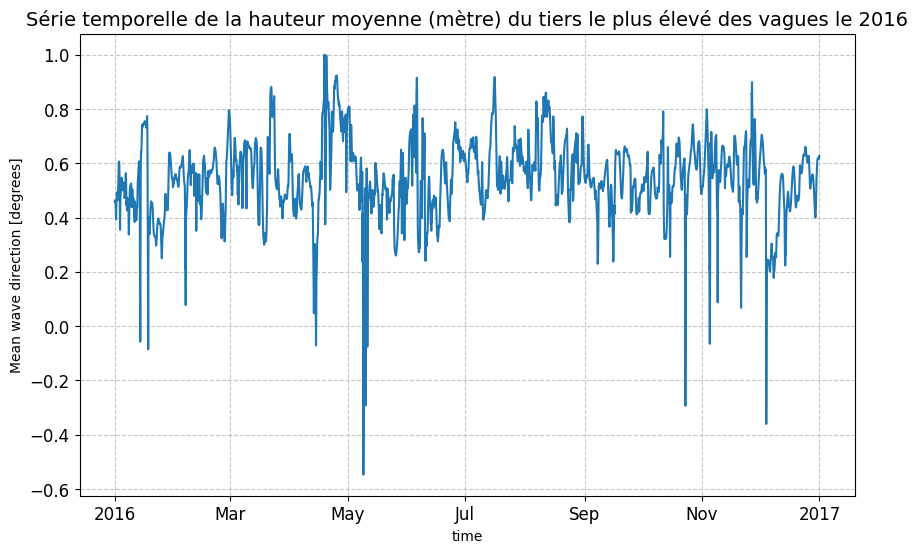

In [74]:
date_filtre = "2016"
table = direction_moyene_des_vagues_2016_2017_biarritz_en_cos
data_filtre = table.sel(time=date_filtre)
fig, ax = plt.subplots(figsize=(10, 6))
data_filtre.plot(ax=ax)  # Tracer les données filtrées
ax.tick_params(axis='both', which='major', labelsize=12)  # Taille des labels des axes
ax.set_title(f"{title} le {date_filtre}", fontsize=14)  # Ajouter le titre correspondant
ax.grid(True, linestyle='--', alpha=0.7)
    
    # Afficher le graphique
plt.show()


# Histogramme et asymétrie

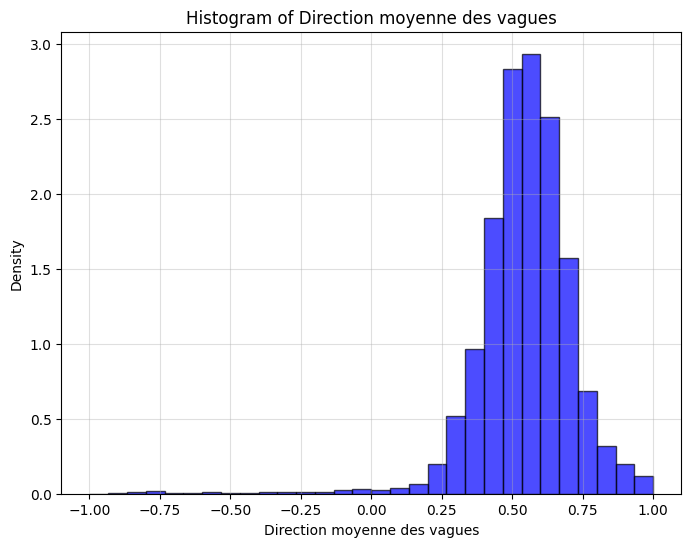

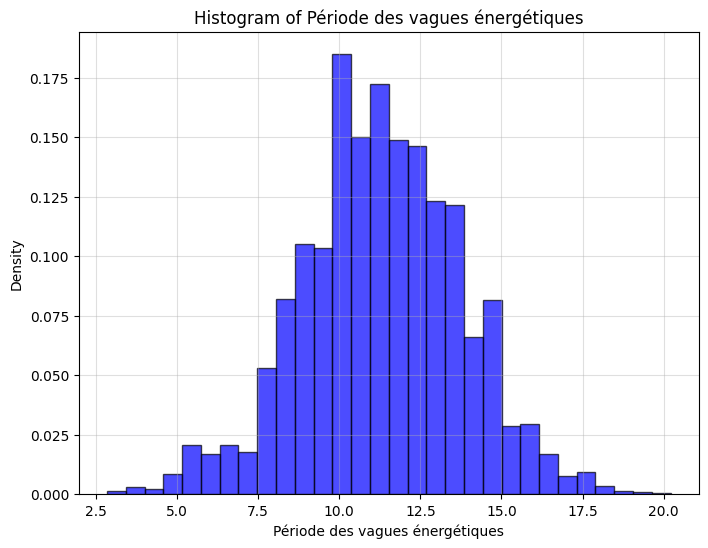

{'Temps moyen entre les vagues': 0.15675724691594703,
 'Direction moyenne des vagues': -2.0676764808337422,
 'Période des vagues énergétiques': -0.06538809853659851,
 'Hauteur moyenne des vagues les plus hautes': 1.6020476606263023}

In [99]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import skew

tables = {
    "Temps moyen entre les vagues": temps_moyen_entre_les_vagues_2016_2017_biarritz,
    "Direction moyenne des vagues": direction_moyene_des_vagues_2016_2017_biarritz_en_cos,
    "Période des vagues énergétiques": temps_moyen_entre_les_vagues_energetiques_2016_2017_biarritz,
    "Hauteur moyenne des vagues les plus hautes": hauteur_moyenne_du_tier_des_vagues_les_plus_hautes_2016_2017_biarritz,
}

skewness_results = {}
for name, data in tables.items():
    # Plot histogram
    plt.figure(figsize=(8, 6))
    plt.hist(data, bins=30, density=True, alpha=0.7, color="blue", edgecolor="black")
    plt.title(f"Histogram of {name}")
    plt.xlabel(name)
    plt.ylabel("Density")
    plt.grid(alpha=0.4)
    plt.show()
    
    skewness = skew(data)
    skewness_results[name] = skewness

skewness_results


- Direction moyenne des vagues fortement négative
-
- Hauteur moyenne des vagues les plus hautes : négative
- Asymétrie positive importante.
- La queue droite est beaucoup plus étendue, indiquant des valeurs élevées rares mais significatives (par exemple, des vagues très hautes).

# Corrélation

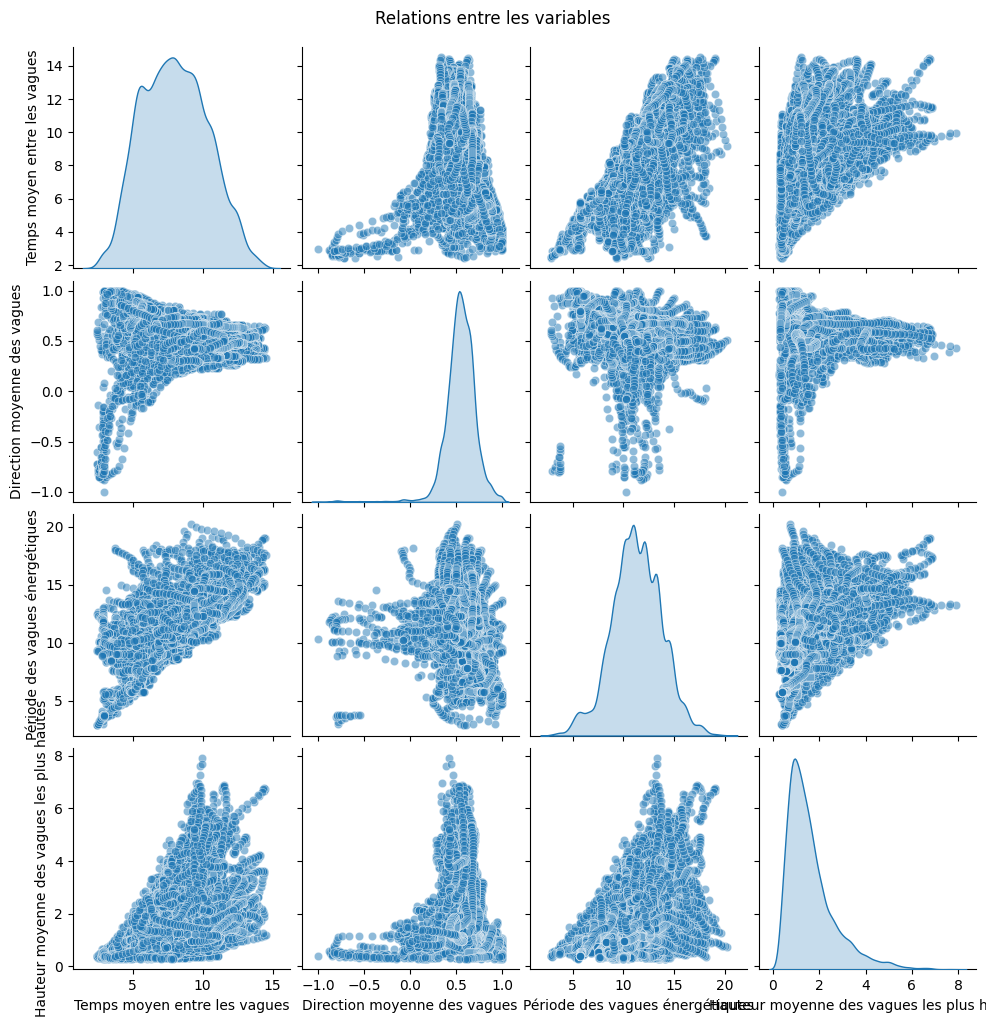

In [100]:
import seaborn as sns

combined_data = pd.DataFrame({
    "Temps moyen entre les vagues": temps_moyen_entre_les_vagues_2016_2017_biarritz.values,
    "Direction moyenne des vagues": direction_moyene_des_vagues_2016_2017_biarritz_en_cos.values,
    "Période des vagues énergétiques": temps_moyen_entre_les_vagues_energetiques_2016_2017_biarritz.values,
    "Hauteur moyenne des vagues les plus hautes": hauteur_moyenne_du_tier_des_vagues_les_plus_hautes_2016_2017_biarritz.values
})

# Calculer la matrice de corrélation
correlation_matrix = combined_data.corr()

# Tracer la matrice de corrélation sous forme de heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f", cbar=True)
plt.title("Matrice de corrélation entre les variables")
plt.show()

# Tracer les relations entre les variables avec un pair plot
sns.pairplot(combined_data, diag_kind="kde", plot_kws={'alpha': 0.5})
plt.suptitle("Relations entre les variables", y=1.02)
plt.show()


- Temps moyen entre les vagues et Période des vagues énergétiques (0.76) : Forte corrélation positive. Cela signifie que lorsque le temps moyen entre les vagues augmente, la période des vagues énergétiques tend également à augmenter. Ces deux variables sont probablement liées aux conditions générales de l'océan.

- Chaque graphique sur la diagonale montre la distribution individuelle de chaque variable (pt pas necessaire de faire des histogrammes)

- Relations entre paires de variables (hors diagonale) :
    + Temps moyen entre les vagues vs Période des vagues énergétiques : Une forte corrélation positive est visible avec un nuage de points aligné en montée.
    + Direction moyenne des vagues vs Autres variables : Les nuages de points montrent une faible corrélation, indiquant peu ou pas de relation.

## filtre par ondelette


sym5 (Symlets) : Bonne approximation des signaux lisses, adaptée aux phénomènes naturels.
coif1 (Coiflets) : Plus adaptée pour les signaux contenant des variations subtiles, souvent utilisée pour les données environnementales.
Pour des séries longues (1 an avec des pas horaires, soit ~8760 points), un niveau de 4 à 6 est souvent idéal
Pour une sous-série (par exemple, un mois, 720 points), utilisez un niveau de 3
Une année à raison de 8 points par jour (24 heures / 3 heures) correspond à environ 2920 observations.


Traitement de la table : Temps moyen entre les vagues


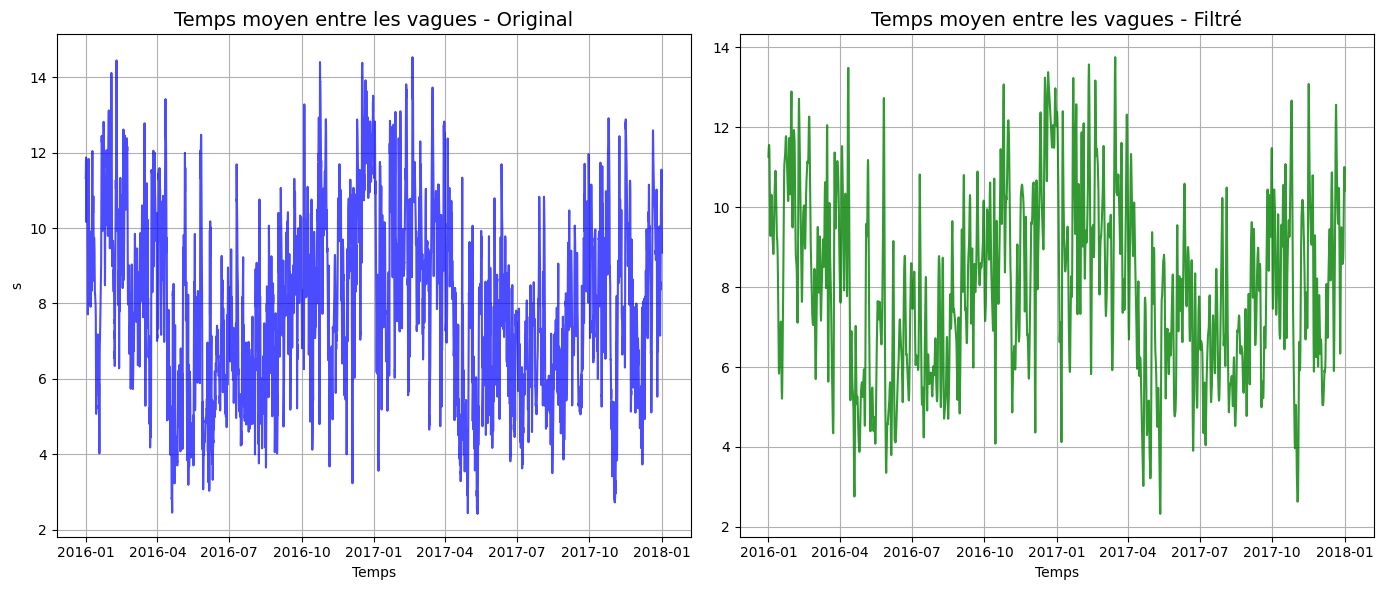

Traitement de la table : Direction moyenne des vagues


Traitement de la table : Période des vagues énergétiques


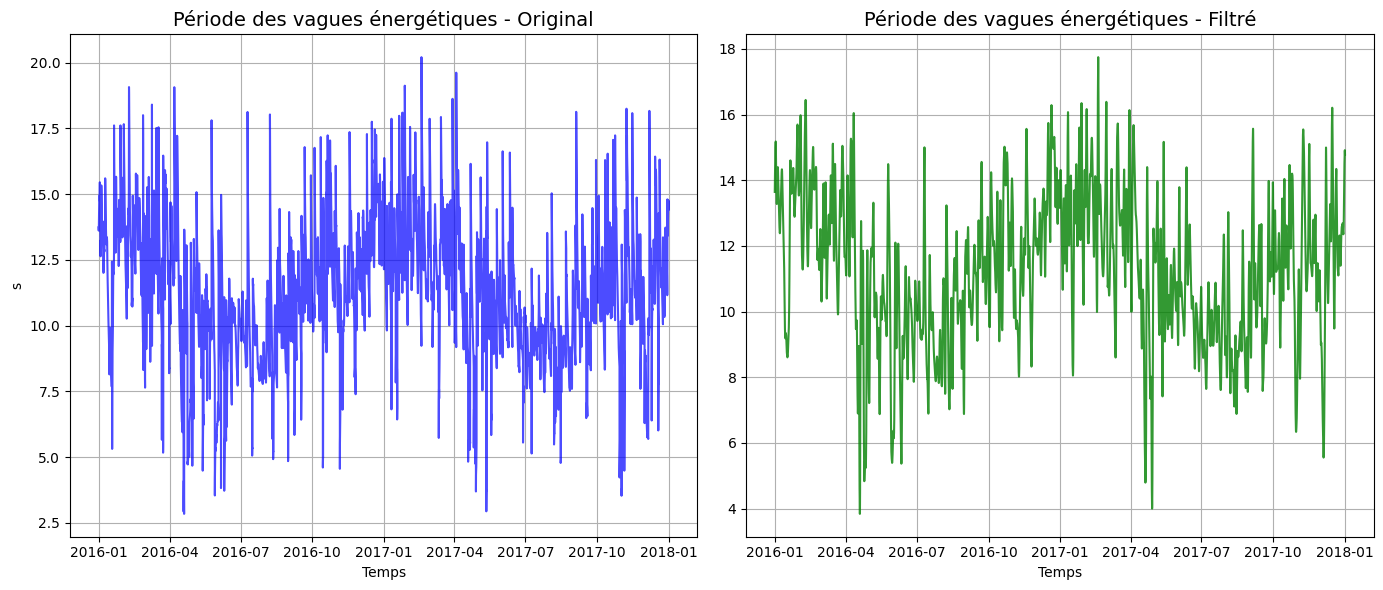

Traitement de la table : Hauteur moyenne des vagues les plus hautes


In [75]:
# Paramètres adaptés aux données climatiques
wavelet = 'sym5'  # Ondelette Symlets 5
level = 5  # Niveau de décomposition pour des séries climatiques (ajusté à la longueur des données)

tables = {
    "Temps moyen entre les vagues": temps_moyen_entre_les_vagues_2016_2017_biarritz,
    "Direction moyenne des vagues": direction_moyene_des_vagues_2016_2017_biarritz_en_cos,
    "Période des vagues énergétiques": temps_moyen_entre_les_vagues_energetiques_2016_2017_biarritz,
    "Hauteur moyenne des vagues les plus hautes": hauteur_moyenne_du_tier_des_vagues_les_plus_hautes_2016_2017_biarritz,
}

for name, data in tables.items():
    print(f"Traitement de la table : {name}")
    
    signal = data.values
    
    coeffs = pywt.wavedec(signal, wavelet, level=level)
    
    coeffs_filtered = coeffs[:]
    for i in range(1, len(coeffs_filtered)):  
        coeffs_filtered[i] = np.zeros_like(coeffs_filtered[i])
    
    signal_filtered = pywt.waverec(coeffs_filtered, wavelet)
    
    filtered_data = xr.DataArray(
        signal_filtered[:len(signal)],  
        dims=data.dims,
        coords=data.coords,
        attrs=data.attrs
    )
    filtered_data.name = f"{name} (Filtré)"
    
    fig, axes = plt.subplots(1, 2, figsize=(14, 6))
    axes[0].plot(data["time"], signal, color="blue", alpha=0.7)
    axes[0].set_title(f"{name} - Original", fontsize=14)
    axes[0].set_xlabel("Temps")
    axes[0].set_ylabel(data.attrs.get('units', 'Valeurs'))
    axes[0].grid(True)
    axes[1].plot(data["time"], signal_filtered[:len(signal)], color="green", alpha=0.8)
    axes[1].set_title(f"{name} - Filtré", fontsize=14)
    axes[1].set_xlabel("Temps")
    axes[1].grid(True)
    
    plt.tight_layout()
    plt.show()


In [76]:
temps_moyen_entre_les_vagues_2016_2017_biarritz_filtre = temps_moyen_entre_les_vagues_2016_2017_biarritz.copy()
direction_moyene_des_vagues_2016_2017_biarritz_en_cos_filtre = direction_moyene_des_vagues_2016_2017_biarritz_en_cos.copy()
temps_moyen_entre_les_vagues_energetiques_2016_2017_biarritz_filtre =temps_moyen_entre_les_vagues_energetiques_2016_2017_biarritz.copy()
hauteur_moyenne_du_tier_des_vagues_les_plus_hautes_2016_2017_biarritz_filtre = hauteur_moyenne_du_tier_des_vagues_les_plus_hautes_2016_2017_biarritz.copy()


def filtrage_par_ondelette(data, wavelet, level):
    # Extraction du signal brut
    signal = data.values

    # Décomposition en ondelettes
    coeffs = pywt.wavedec(signal, wavelet, level=level)

    for i in range(1, len(coeffs)):
        coeffs[i] = np.zeros_like(coeffs[i])

    signal_filtered = pywt.waverec(coeffs, wavelet)

    signal_filtered = signal_filtered[:len(signal)]

    return xr.DataArray(
        signal_filtered,
        dims=data.dims,
        coords=data.coords,
        attrs=data.attrs,
    )

# Application du filtrage à chaque table
temps_moyen_entre_les_vagues_2016_2017_biarritz_filtre = filtrage_par_ondelette(
    temps_moyen_entre_les_vagues_2016_2017_biarritz_filtre, wavelet, level
)

direction_moyene_des_vagues_2016_2017_biarritz_en_cos_filtre = filtrage_par_ondelette(
    direction_moyene_des_vagues_2016_2017_biarritz_en_cos_filtre, wavelet, level
)

temps_moyen_entre_les_vagues_energetiques_2016_2017_biarritz_filtre = filtrage_par_ondelette(
    temps_moyen_entre_les_vagues_energetiques_2016_2017_biarritz_filtre, wavelet, level
)

hauteur_moyenne_du_tier_des_vagues_les_plus_hautes_2016_2017_biarritz_filtre = filtrage_par_ondelette(
    hauteur_moyenne_du_tier_des_vagues_les_plus_hautes_2016_2017_biarritz_filtre, wavelet, level
)


## NA

In [77]:
tables = {
    "Temps moyen entre les vagues": temps_moyen_entre_les_vagues_2016_2017_biarritz_filtre,
    "Direction moyenne des vagues": direction_moyene_des_vagues_2016_2017_biarritz_en_cos_filtre,
    "Période des vagues énergétiques": temps_moyen_entre_les_vagues_energetiques_2016_2017_biarritz_filtre,
    "Hauteur moyenne des vagues les plus hautes": hauteur_moyenne_du_tier_des_vagues_les_plus_hautes_2016_2017_biarritz_filtre,
}

for name, data in tables.items():
    nan_count = data.isnull().sum().values  
    print(f"{name} : Nombre de NaN : {nan_count}")


Temps moyen entre les vagues : Nombre de NaN : 0
Direction moyenne des vagues : Nombre de NaN : 0
Période des vagues énergétiques : Nombre de NaN : 0
Hauteur moyenne des vagues les plus hautes : Nombre de NaN : 0


## Convertion en format dataframe 

In [78]:
tables = {
    "Temps moyen entre les vagues": temps_moyen_entre_les_vagues_2016_2017_biarritz_filtre,
    "Direction moyenne des vagues": direction_moyene_des_vagues_2016_2017_biarritz_en_cos_filtre,
    "Période des vagues énergétiques": temps_moyen_entre_les_vagues_energetiques_2016_2017_biarritz_filtre,
    "Hauteur moyenne des vagues les plus hautes": hauteur_moyenne_du_tier_des_vagues_les_plus_hautes_2016_2017_biarritz_filtre,
}

dataframes = {}

# Processus de conversion
for name, data in tables.items():    
    # Vérifier si le DataArray a un nom, sinon lui en attribuer un
    if data.name is None:
        data.name = name  # Donner un nom basé sur le nom de la table
    
    # Convertir chaque DataArray en DataFrame pandas
    df = data.to_dataframe()  # On convertit la série en pandas DataFrame
    
    # Nous supposons que l'index est déjà 'time' et que ce dernier est bien synchronisé entre les séries.
    df['time'] = df.index  # Ajouter explicitement l'index comme colonne 'time' (si ce n'est pas déjà le cas)
    
    # Ajouter le DataFrame dans le dictionnaire des DataFrames
    dataframes[name] = df

# Fusionner toutes les tables sur 'time'
series_informations_vagues_2016_2017_biarritz = pd.concat(dataframes.values(), axis=1)  # Fusionner toutes les tables sur 'time'

# Renommer les colonnes pour éviter les conflits
series_informations_vagues_2016_2017_biarritz.columns = [f"{col}" for name, df in dataframes.items() for col in df.columns]

# Supprimer les colonnes doublons (_time, _x_coordinate, _y_coordinate)
columns_to_remove = [col for col in series_informations_vagues_2016_2017_biarritz.columns if '_time' in col or '_x_coordinate' in col or '_y_coordinate' in col or 'time' in col]
series_informations_vagues_2016_2017_biarritz.drop(columns=columns_to_remove, inplace=True)



In [79]:
series_informations_vagues_2016_2017_biarritz.head(5)

Temps moyen entre les vagues  \
time                                                
2016-01-01 00:00:00                     11.266698   
2016-01-01 01:00:00                     11.279414   
2016-01-01 02:00:00                     11.296288   
2016-01-01 03:00:00                     11.319265   
2016-01-01 04:00:00                     11.348407   

                     Direction moyenne des vagues  \
time                                                
2016-01-01 00:00:00                      0.456256   
2016-01-01 01:00:00                      0.456368   
2016-01-01 02:00:00                      0.456487   
2016-01-01 03:00:00                      0.456612   
2016-01-01 04:00:00                      0.456741   

                     Période des vagues énergétiques  \
time                                                   
2016-01-01 00:00:00                        13.644082   
2016-01-01 01:00:00                        13.697145   
2016-01-01 02:00:00                        13.759758   
2016-01-01 03:00:00                        13.836108   
2016-01-01 04:00:00                        13.926270   

                     Hauteur moyenne des vagues les plus hautes  
time                                                             
2016-01-01 00:00:00                                    2.803374  
2016-01-01 01:00:00                                    2.839267  
2016-01-01 02:00:00                                    2.881725  
2016-01-01 03:00:00                                    2.933501  
2016-01-01 04:00:00                                    2.994632

In [80]:
assert len(series_informations_vagues_2016_2017_biarritz) == 24*365*2+24 #2016 est une année bissextile

In [81]:
series_informations_vagues_2016_2017_biarritz.dtypes

Temps moyen entre les vagues                  float64
Direction moyenne des vagues                  float64
Période des vagues énergétiques               float64
Hauteur moyenne des vagues les plus hautes    float64
dtype: object

In [82]:
series_informations_vagues_2016_2017_biarritz.columns

Index(['Temps moyen entre les vagues', 'Direction moyenne des vagues',
       'Période des vagues énergétiques',
       'Hauteur moyenne des vagues les plus hautes'],
      dtype='object')

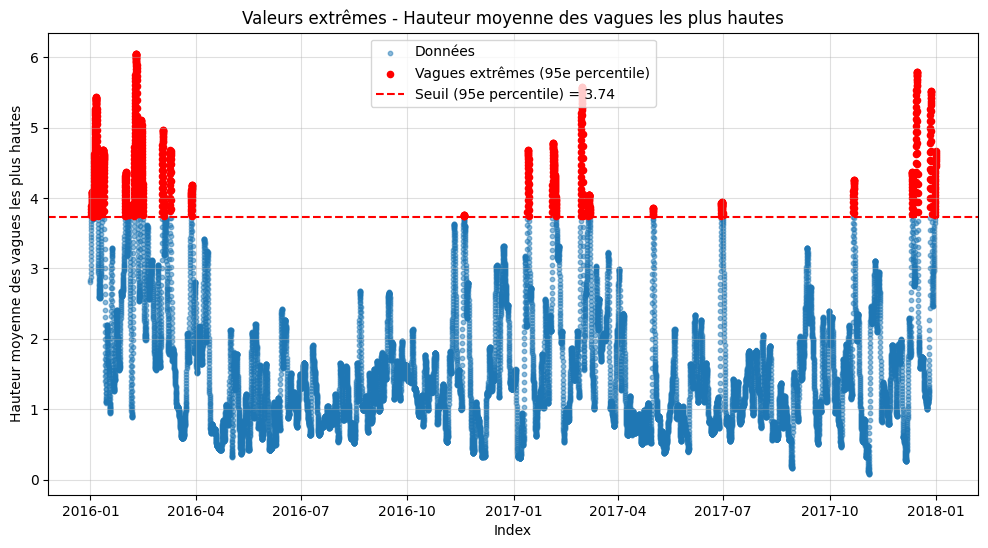

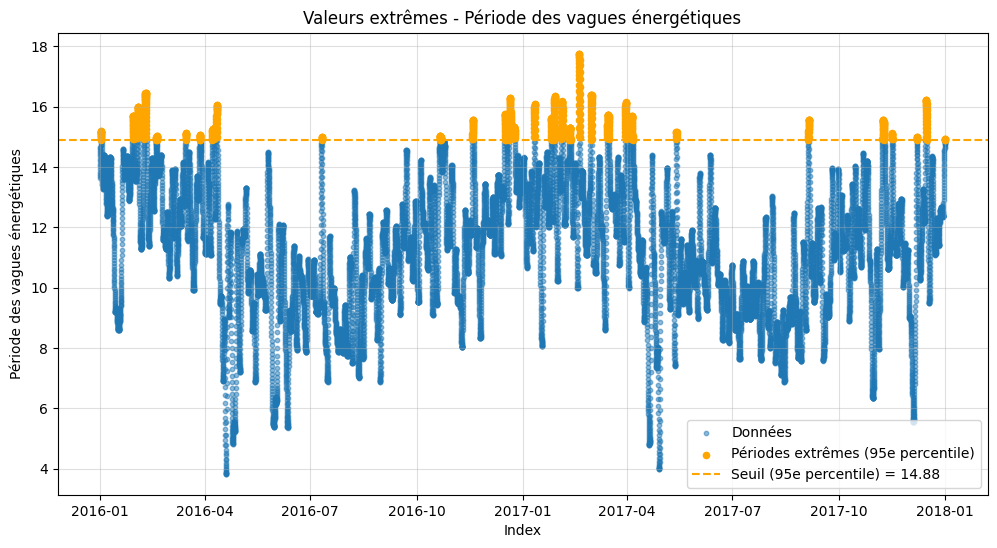

In [102]:
# Seuils pour définir les valeurs extrêmes (95e percentile)
threshold_height = series_informations_vagues_2016_2017_biarritz["Hauteur moyenne des vagues les plus hautes"].quantile(0.95)
threshold_period = series_informations_vagues_2016_2017_biarritz["Période des vagues énergétiques"].quantile(0.95)

# Identifier les valeurs extrêmes
extreme_wave_heights = series_informations_vagues_2016_2017_biarritz[series_informations_vagues_2016_2017_biarritz["Hauteur moyenne des vagues les plus hautes"] > threshold_height]
extreme_wave_periods = series_informations_vagues_2016_2017_biarritz[series_informations_vagues_2016_2017_biarritz["Période des vagues énergétiques"] > threshold_period]

# Visualiser les valeurs extrêmes pour la hauteur des vagues
plt.figure(figsize=(12, 6))
plt.scatter(series_informations_vagues_2016_2017_biarritz.index, 
            series_informations_vagues_2016_2017_biarritz["Hauteur moyenne des vagues les plus hautes"], 
            alpha=0.5, s=10, label="Données")  # Taille des points réduite
plt.scatter(extreme_wave_heights.index, 
            extreme_wave_heights["Hauteur moyenne des vagues les plus hautes"],
            color="red", s=20, label="Vagues extrêmes (95e percentile)")  # Points extrêmes légèrement plus grands
plt.axhline(y=threshold_height, color="red", linestyle="--", label=f"Seuil (95e percentile) = {threshold_height:.2f}")
plt.title("Valeurs extrêmes - Hauteur moyenne des vagues les plus hautes")
plt.xlabel("Index")
plt.ylabel("Hauteur moyenne des vagues les plus hautes")
plt.legend()
plt.grid(alpha=0.4)
plt.show()

# Visualiser les valeurs extrêmes pour la période des vagues énergétiques
plt.figure(figsize=(12, 6))
plt.scatter(series_informations_vagues_2016_2017_biarritz.index, 
            series_informations_vagues_2016_2017_biarritz["Période des vagues énergétiques"], 
            alpha=0.5, s=10, label="Données")  # Taille des points réduite
plt.scatter(extreme_wave_periods.index, 
            extreme_wave_periods["Période des vagues énergétiques"],
            color="orange", s=20, label="Périodes extrêmes (95e percentile)")  # Points extrêmes légèrement plus grands
plt.axhline(y=threshold_period, color="orange", linestyle="--", label=f"Seuil (95e percentile) = {threshold_period:.2f}")
plt.title("Valeurs extrêmes - Période des vagues énergétiques")
plt.xlabel("Index")
plt.ylabel("Période des vagues énergétiques")
plt.legend()
plt.grid(alpha=0.4)
plt.show()


## ajout de feature : regarder notbook du prof

### lags

So on fait une modélisation pour les 24h suivant on a pas accès aux 24 derners lags. Ici on commence à prédire heure par heure donc on utiliser tous les lags

In [ ]:
# # Définir le nombre de lags pour chaque variable
# variables = {
#     "Temps moyen entre les vagues": 5,
#     "Direction moyenne des vagues": 2,
#     "Période des vagues énergétiques": 3,
#     "Hauteur moyenne des vagues les plus hautes": 5,
# }

# # Copier le DataFrame initial
# series_informations_vagues_2016_2017_biarritz_avec_lag = series_informations_vagues_2016_2017_biarritz.copy()

# # Ajouter les lags pour chaque variable
# for var, n_lags in variables.items():
#     for lag in range(1, n_lags + 1):  # Créer des colonnes de décalage (1 à n_lags)
#         series_informations_vagues_2016_2017_biarritz_avec_lag[f"{var}_lag_{lag}"] = merge_df_with_lags[var].shift(lag)

# series_informations_vagues_2016_2017_biarritz_avec_lag.head()


Temps moyen entre les vagues  \
time                                                
2016-01-01 00:00:00                      4.920377   
2016-01-01 01:00:00                      4.897542   
2016-01-01 02:00:00                      4.871456   
2016-01-01 03:00:00                      4.840635   
2016-01-01 04:00:00                      4.805043   

                     Direction moyenne des vagues  \
time                                                
2016-01-01 00:00:00                     -0.605356   
2016-01-01 01:00:00                     -0.600275   
2016-01-01 02:00:00                     -0.594618   
2016-01-01 03:00:00                     -0.588131   
2016-01-01 04:00:00                     -0.580803   

                     Période des vagues énergétiques  \
time                                                   
2016-01-01 00:00:00                         6.695592   
2016-01-01 01:00:00                         6.653560   
2016-01-01 02:00:00                         6.606068   
2016-01-01 03:00:00                         6.550678   
2016-01-01 04:00:00                         6.487347   

                     Hauteur moyenne des vagues les plus hautes  \
time                                                              
2016-01-01 00:00:00                                    2.069141   
2016-01-01 01:00:00                                    2.053123   
2016-01-01 02:00:00                                    2.035293   
2016-01-01 03:00:00                                    2.014816   
2016-01-01 04:00:00                                    1.991655   

                     Temps moyen entre les vagues_lag_1  \
time                                                      
2016-01-01 00:00:00                                 NaN   
2016-01-01 01:00:00                            4.920377   
2016-01-01 02:00:00                            4.897542   
2016-01-01 03:00:00                            4.871456   
2016-01-01 04:00:00                            4.840635   

                     Temps moyen entre les vagues_lag_2  \
time                                                      
2016-01-01 00:00:00                                 NaN   
2016-01-01 01:00:00                                 NaN   
2016-01-01 02:00:00                            4.920377   
2016-01-01 03:00:00                            4.897542   
2016-01-01 04:00:00                            4.871456   

                     Temps moyen entre les vagues_lag_3  \
time                                                      
2016-01-01 00:00:00                                 NaN   
2016-01-01 01:00:00                                 NaN   
2016-01-01 02:00:00                                 NaN   
2016-01-01 03:00:00                            4.920377   
2016-01-01 04:00:00                            4.897542   

                     Temps moyen entre les vagues_lag_4  \
time                                                      
2016-01-01 00:00:00                                 NaN   
2016-01-01 01:00:00                                 NaN   
2016-01-01 02:00:00                                 NaN   
2016-01-01 03:00:00                                 NaN   
2016-01-01 04:00:00                            4.920377   

                     Temps moyen entre les vagues_lag_5  \
time                                                      
2016-01-01 00:00:00                                 NaN   
2016-01-01 01:00:00                                 NaN   
2016-01-01 02:00:00                                 NaN   
2016-01-01 03:00:00                                 NaN   
2016-01-01 04:00:00                                 NaN   

                     Direction moyenne des vagues_lag_1  \
time                                                      
2016-01-01 00:00:00                                 NaN   
2016-01-01 01:00:00                           -0.605356   
2016-01-01 02:00:00                           -0.600275   
2016-01-01 03:00:00                           -0.

!pip install tsfresh

# Modelisation 


cible 
- question importante. Peut être pas prédire la hauteur dans l'absolue mais la hateur par rapport à la hauteur moyenne ou médiane ? (cf Quantmétrie).A voir, peut être pas utile si c'est stationnaire

base line 
future = present

question temporalité/spacialité : 
- chaque spots sont indépendants? 
- utiliser lag inférieur des autres spot proche ?
Modèle  
- choix : modèle recursif ou direct ou hybride?
- fôret, GB?
- faire du padling ? i.e utiliser lag
- Light GBM
- stacking avec elastic net comme méta model et different données d'entrainement pour chaque couche
- CNN ?
- modèle LTSM ? meilleure persistance de l’information par rapport aux RNN classiques, grâce au “transport” de l’information au fil du temps par cet état caché que l’on appelle la “cell state”

## découpage train, test et validation

Le découpage ne mélange pas les observations afin de préserver la nature séquentielle des données, pour ne pas risquer une fuite de données (future leakage)

In [ ]:
series_data = series_informations_vagues_2016_2017_biarritz.sort_index()

# Taille totale des données
total_size = len(series_data)

# Proportions pour train, validation, et test
train_ratio = 0.7  # 70 % pour l'entraînement
val_ratio = 0.15   # 15 % pour la validation
test_ratio = 0.15  # 15 % pour le test

# Calcul des indices pour découpage
train_end = int(total_size * train_ratio)
val_end = int(total_size * (train_ratio + val_ratio))

# Découpage en ensembles temporels
train_data = series_data.iloc[:train_end]
val_data = series_data.iloc[train_end:val_end]
test_data = series_data.iloc[val_end:]

# Affichage des résultats
print(f"Train: {len(train_data)} observations")
print(f"Validation: {len(val_data)} observations")
print(f"Test: {len(test_data)} observations")

# Vérification
print("Train index range:", train_data.index.min(), "-", train_data.index.max())
print("Validation index range:", val_data.index.min(), "-", val_data.index.max())
print("Test index range:", test_data.index.min(), "-", test_data.index.max())


Train: 12280 observations
Validation: 2632 observations
Test: 2632 observations
Train index range: 2016-01-01 00:00:00 - 2017-05-26 15:00:00
Validation index range: 2017-05-26 16:00:00 - 2017-09-13 07:00:00
Test index range: 2017-09-13 08:00:00 - 2017-12-31 23:00:00


## modèle bse line

simple : yT+h/T = yT